# Data Processing Checklist

## Compute all the indexes
- [ ] Seasonal indexes (
    - [ ] SST 
    - [ ] HGT
    - [ ] SLP
- [ ] Plot Index + PSD Plots
- [ ] Smoothed indexes (SST + SLP)
- [ ] Zscores 
- [ ] Duration 
    - [ ] Per Year 
    = [ ] Per 4-5 Years (Moving Average)
    - [ ] Per Decade

## Compute for: (Common Climatology - 1980-2010 (or 1990-2020?))
- [ ] Short-term [1980-2023]
- [ ] Long-term [1901-2023]

## Combine datasets
- [ ] Merge all results into one xarrays
    - [ ] Short-term
    - [ ] Long-term
    
## Plot Index Figures
- [ ] Combined Index with PSD
- [ ] Highest and Lowest 10 Years ( Composites (Over the Ocean?? TBD)

# Load Packages + Filepath

In [62]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import xcdat as xc
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import scipy#

In [3]:
# from matplotlib import pyplot as plt
# from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
# import matplotlib.dates as mdates

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# from scipy import stats
# from scipy.stats import pearsonr
# from scipy.stats import zscore
# from scipy.stats import t
# from scipy.signal import butter, filtfilt, detrend, welch

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Load Local Utils
import plotting_utils
import index_utils

In [6]:
input_filepath1 = "../../data/"
input_filepath2 = "../../data/created/"

In [7]:
# # Copy Time Length and Style from ENSO.
# #enso_processed['seasonal'].time.to_netcdf("data/TIME.nc") 

# time_seasonal = xr.open_dataset("data/TIME.nc")#.rename({'latitude': 'lat', 'longitude': 'lon'}).bounds.add_missing_bounds()
# time_seasonal

# Load General Functions

### Regression and Correlation

In [8]:
def linear_reg_with_corr_p(pc_series, field, years):
    # Set matching time coordinates
    pc_series = pc_series.copy()
    field = field.copy()
    pc_series['time'] = years
    field['time'] = years

    # sample size
    n = field.sizes['time']
    dof = n - 2
    
    reg = xr.cov(field, pc_series, dim='time')

    # correlation map
    corr = xr.corr(field, pc_series, dim='time')

    # compute t-statistic
    tval = corr * np.sqrt(dof / (1 - corr**2))

    # compute two-tailed p-value
    p = xr.apply_ufunc(
        lambda x: 2 * (1 - t.cdf(np.abs(x), dof)),
        tval
    )

    return reg, corr, p

In [ ]:
def compute_and_plot_reg_with_corrs_p_MOV(idx_values,
                           pdsi_anoms_seasonal, 
                           sst_anoms_seasonal,
                           years, seasons,
                           cmap_pdsi='BrBG', vlim_pdsi=0.5,
                           cmap_sst='RdBu_r', vlim_sst=0.5,
                           overall_title = "Regession with Correlation P",
                           coeff_label='Regression'):

    pdsi_reg_dt = []
    sst_reg_dt = []
    pdsi_pvals_dt = []
    sst_pvals_dt = []
    dual_sel_titles = []

    for season in seasons:
        # Get and detrend index values for this seaason
        #idx_values = index_results[index_key_prefix_1][season][level_idx][index_key_prefix_2 + season]

        # Correlation with PDSI
        reg_pdsi, corr_pdsi, p_pdsi = linear_reg_with_corr_p(
            detrend_dim(idx_values[season], 'time'),
            detrend_dim(pdsi_anoms_seasonal[season], 'time'),
            years
        )

        # Correlation with SST
        reg_sst, corr_sst, p_sst = linear_reg_with_corr_p(
            detrend_dim(idx_values[season], 'time'),
            detrend_dim(sst_anoms_seasonal[season], 'time'),
            years
        )

        pdsi_reg_dt.append(reg_pdsi)
        sst_reg_dt.append(reg_sst)
        pdsi_pvals_dt.append(p_pdsi)
        sst_pvals_dt.append(p_sst)

        # Title for subplot
        #title = f"SST {season} Correlated and PDSI {season}\n with PDSI {season} {index_key_prefix[:-1]}"
        title = f"{season}"
        dual_sel_titles.append(title)

    # Plot
    four_reg_plot_with_sig(
        pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
        sst_reg_dt, cmap_sst, vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        'pdsi_reg': pdsi_reg_dt,
        'sst_reg': sst_reg_dt,
        'pdsi_pvals': pdsi_pvals_dt,
        'sst_pvals': sst_pvals_dt
    }


In [ ]:
# SEAS = ["DJF","MAM","JJA","SON"]

# def _shift_season(name, k):
#     i = SEAS.index(name); j = i + k
#     return SEAS[j % 4], j // 4

# def _get_season(da, season, year_dim="year"):
#     # Accept dicts or DA with a 'season' coord; return DA for this season with 'year' dim
#     x = da[season] if isinstance(da, dict) else da.sel(season=season)
#     if year_dim not in x.dims and "time" in x.dims:  # allow 'time'→'year'
#         x = x.rename({"time": year_dim})
#     return x

# def _detrend(y, dim="year"):
#     n = int(y.sizes.get(dim, 0))
#     if n < 3: return y
#     tnum = xr.DataArray(np.arange(n), dims=[dim], coords={dim: y[dim]})
#     pf = y.polyfit(dim=dim, deg=1, skipna=True)
#     return y - xr.polyval(tnum, pf.polyfit_coefficients)

# def _reg_corr_p(x, Y, dim="year"):
#     x, Y = xr.align(x, Y, join="inner")
#     n = int(Y.sizes.get(dim, 0))
#     if n < 3:
#         base = Y.isel({dim:0}, drop=True)*np.nan
#         return base, base, base
#     dof = n - 2
#     reg  = xr.cov(Y, x, dim=dim)
#     corr = xr.corr(Y, x, dim=dim)
#     tval = corr * np.sqrt(dof / (1 - corr**2))
#     pval = xr.apply_ufunc(lambda v: 2*(1 - t.cdf(np.abs(v), dof)), tval)
#     return reg, corr, pval

# def regs_from_seasonal(
#     idx_seasonal,           # seasonal index: dict or DA with coord 'season' and dim 'year' (or 'time')
#     pdsi_seasonal,          # seasonal PDSI field: same season structure, dims ('year','lat','lon')
#     sst_seasonal,           # seasonal SST field: same
#     seasons=("DJF","MAM","JJA","SON"),
#     lag_seasons=0,          # 0, 1, or 2 (index leads if index_leads=True)
#     lag_years=0,            # 0 or 1
#     index_leads=True,       # True: index leads (fields lag). False: fields lead (index lags)
#     year_dim="year"
# ):
#     out = {"pdsi_reg":[], "sst_reg":[], "pdsi_pvals":[], "sst_pvals":[], "titles":[]}

#     for s in seasons:
#         # index (this season)
#         x = _get_season(idx_seasonal, s, year_dim)

#         # which field season pairs with this index season?
#         tgt_s, wrap = _shift_season(s, lag_seasons if index_leads else -lag_seasons)
#         Yp = _get_season(pdsi_seasonal, tgt_s, year_dim)
#         Ys = _get_season(sst_seasonal,  tgt_s, year_dim)

#         total = wrap + (lag_years if index_leads else -lag_years)

#         # shift the series that LAGS
#         if index_leads and total:
#             Yp = Yp.shift({year_dim: -total});  Ys = Ys.shift({year_dim: -total})
#         elif (not index_leads) and total:
#             x  = x.shift({year_dim: -total})

#         # detrend all
#         xd  = _detrend(x,  year_dim)
#         Ypd = _detrend(Yp, year_dim)
#         Ysd = _detrend(Ys, year_dim)

#         # regress/corr/p
#         rP, cP, pP = _reg_corr_p(xd, Ypd, year_dim)
#         rS, cS, pS = _reg_corr_p(xd, Ysd, year_dim)

#         out["pdsi_reg"].append(rP); out["sst_reg"].append(rS)
#         out["pdsi_pvals"].append(pP); out["sst_pvals"].append(pS)

#         tag = []
#         if lag_seasons: tag.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
#         if lag_years:   tag.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
#         out["titles"].append(f"{s} ({', '.join(tag) if tag else 'no lag'})")

#     return out

#### Plot Correlation / Regression

In [ ]:
def four_reg_plot_with_sig(var, var_cmap, var_vval,
                           var_2, var_cmap_2, var_vval_2,
                           pvals1, pvals2,  # lists of p-value DataArrays
                           val_sel_titles, overall_title,
                           var_label):
    robinson = ccrs.Robinson()

    # Use constrained layout to minimize whitespace automatically
    fig, axes = plt.subplots(
        2, 2, figsize=(12, 8),
        subplot_kw={'projection': robinson},
        constrained_layout=True
    )
    
        # fig, axes = plt.subplots(2, 2, figsize=(16, 8),
        #                      subplot_kw={'projection': robinson})
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    # Make colormaps with fixed bins once (avoids re-creating inside loop)
    cmap1 = plt.get_cmap(var_cmap, 10)
    cmap2 = plt.get_cmap(var_cmap_2, 10)

    for i, ax in enumerate(axes.flatten()):
        v1 = var[i]
        v2 = var_2[i]
        p1 = pvals1[i]
        p2 = pvals2[i]

        ax.coastlines(resolution='110m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.25, linestyle='--')

        # Gridlines + larger label size
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.025, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}   # bigger labels
        gl.ylabel_style = {'size': 14}

        # === Base data for var1
        lats = v1.lat
        lons = v1.lon
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        pcm1 = ax.pcolormesh(lon_grid, lat_grid, v1,
                             cmap=cmap1,
                             vmin=-var_vval, vmax=var_vval,
                             transform=ccrs.PlateCarree())

        # === Base data for var2
        lats2 = v2.lat
        lons2 = v2.lon
        lon_grid2, lat_grid2 = np.meshgrid(lons2, lats2)
        pcm2 = ax.pcolormesh(lon_grid2, lat_grid2, v2,
                             cmap=cmap2,
                             vmin=-var_vval_2, vmax=var_vval_2,
                             transform=ccrs.PlateCarree())

        # === Overlay significance mask for var1 (hatch non-sig)
        nonsig_mask1 = p1 > 0.05
        ax.contourf(lon_grid, lat_grid, nonsig_mask1,
                    levels=[0.5, 1], colors='none',
                    hatches=['....'], transform=ccrs.PlateCarree())

        # === Overlay significance mask for var2 (hatch non-sig)
        nonsig_mask2 = p2 > 0.05
        ax.contourf(lon_grid2, lat_grid2, nonsig_mask2,
                    levels=[0.5, 1], colors='none',
                    hatches=['....'], transform=ccrs.PlateCarree())

        ax.set_title(val_sel_titles[i], fontsize=16, y=1.0, fontweight="bold")

    # Shared colorbars inside the figure (no negative offsets), bigger ticks/labels
    # Left column (maps 0,2) uses var1 colorbar
    cb1 = fig.colorbar(
        pcm1, ax=axes[:, 0].ravel().tolist(),
        orientation='horizontal', fraction=0.06, pad=0.07, extend='both', shrink = 0.85
    )
    cb1.ax.tick_params(labelsize=14)        # bigger tick labels
    cb1.set_label(var_label, fontsize=15)   # bigger cbar label

    # Right column (maps 1,3) uses var2 colorbar
    cb2 = fig.colorbar(
        pcm2, ax=axes[:, 1].ravel().tolist(),
        orientation='horizontal', fraction=0.06, pad=0.07, extend='both', shrink = 0.85
    )
    cb2.ax.tick_params(labelsize=14)
    cb2.set_label(var_label, fontsize=15)

    # Compact, high-placed title
    fig.suptitle(overall_title, fontweight="bold", fontsize=18, y=1.05)

    plt.show()

In [ ]:
def single_reg_plot_with_sig(var, var_cmap, var_vval,
                           var_2, var_cmap_2, var_vval_2,
                           pvals1, pvals2,  # lists of p-value DataArrays
                           val_sel_titles, overall_title,
                           var_label):
    robinson = ccrs.Robinson()

    # Use constrained layout to minimize whitespace automatically
    fig, axes = plt.subplots(
        1, 1, figsize=(12, 8),
        subplot_kw={'projection': robinson},
        constrained_layout=True
    )
    
        # fig, axes = plt.subplots(2, 2, figsize=(16, 8),
        #                      subplot_kw={'projection': robinson})
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    # Make colormaps with fixed bins once (avoids re-creating inside loop)
    cmap1 = plt.get_cmap(var_cmap, 10)
    cmap2 = plt.get_cmap(var_cmap_2, 10)

    for i, ax in enumerate(axes.flatten()):
        v1 = var[i]
        v2 = var_2[i]
        p1 = pvals1[i]
        p2 = pvals2[i]

        ax.coastlines(resolution='110m', linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.25, linestyle='--')

        # Gridlines + larger label size
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.025, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}   # bigger labels
        gl.ylabel_style = {'size': 14}

        # === Base data for var1
        lats = v1.lat
        lons = v1.lon
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        pcm1 = ax.pcolormesh(lon_grid, lat_grid, v1,
                             cmap=cmap1,
                             vmin=-var_vval, vmax=var_vval,
                             transform=ccrs.PlateCarree())

        # === Base data for var2
        lats2 = v2.lat
        lons2 = v2.lon
        lon_grid2, lat_grid2 = np.meshgrid(lons2, lats2)
        pcm2 = ax.pcolormesh(lon_grid2, lat_grid2, v2,
                             cmap=cmap2,
                             vmin=-var_vval_2, vmax=var_vval_2,
                             transform=ccrs.PlateCarree())

        # === Overlay significance mask for var1 (hatch non-sig)
        nonsig_mask1 = p1 > 0.05
        ax.contourf(lon_grid, lat_grid, nonsig_mask1,
                    levels=[0.5, 1], colors='none',
                    hatches=['....'], transform=ccrs.PlateCarree())

        # === Overlay significance mask for var2 (hatch non-sig)
        nonsig_mask2 = p2 > 0.05
        ax.contourf(lon_grid2, lat_grid2, nonsig_mask2,
                    levels=[0.5, 1], colors='none',
                    hatches=['....'], transform=ccrs.PlateCarree())

        ax.set_title(val_sel_titles[i], fontsize=16, y=1.0, fontweight="bold")

    # Shared colorbars inside the figure (no negative offsets), bigger ticks/labels
    # Left column (maps 0,2) uses var1 colorbar
    cb1 = fig.colorbar(
        pcm1, ax=axes[:, 0].ravel().tolist(),
        orientation='horizontal', fraction=0.06, pad=0.07, extend='both', shrink = 0.85
    )
    cb1.ax.tick_params(labelsize=14)        # bigger tick labels
    cb1.set_label(var_label, fontsize=15)   # bigger cbar label

    # Right column (maps 1,3) uses var2 colorbar
    cb2 = fig.colorbar(
        pcm2, ax=axes[:, 1].ravel().tolist(),
        orientation='horizontal', fraction=0.06, pad=0.07, extend='both', shrink = 0.85
    )
    cb2.ax.tick_params(labelsize=14)
    cb2.set_label(var_label, fontsize=15)

    # Compact, high-placed title
    fig.suptitle(overall_title, fontweight="bold", fontsize=18, y=1.05)

    plt.show()

In [ ]:
def plot_teleconnection_dual_projection(var, index_data, filtered_index,
                                        index_name,
                                        map_title,
                                        titles=("Regular", "Pacific-Centered", "Index Time Series"),
                                        cmap="RdBu_r",
                                        vrange=(-1, 1),
                                        discrete_bins=21,
                                        figsize=(22, 5),
                                        index_label="Nino3.4"):

    fig = plt.figure(figsize=figsize)
    cmap1 = plt.get_cmap(cmap, discrete_bins)

    # First Map: Regular Projection
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1, projection=ccrs.Robinson())
    ax1.coastlines(resolution='110m', linewidth=0.5)

    lon1, lat1 = np.meshgrid(var.lon, var.lat)
    pcm1 = ax1.pcolormesh(lon1, lat1, var,
                          cmap=cmap1,
                          vmin=vrange[0], vmax=vrange[1],
                          transform=ccrs.PlateCarree())
    
    gl1 = ax1.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    #gl1.top_labels = False
    gl1.bottom_labels = True
    gl1.left_labels = True
    #gl1.right_labels = False

    # Second Map: Pacific-Centered
    ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=1, projection=ccrs.Robinson(central_longitude=180))
    ax2.coastlines(resolution='110m', linewidth=0.5)

    if var.lon.min() < 0:
        var_pc = var.assign_coords(lon=((var.lon + 360) % 360)).sortby('lon')
    else:
        var_pc = var.copy()
    lon2, lat2 = np.meshgrid(var_pc.lon, var_pc.lat)

    pcm2 = ax2.pcolormesh(lon2, lat2, var_pc,
                          cmap=cmap1,
                          vmin=vrange[0], vmax=vrange[1],
                          transform=ccrs.PlateCarree())
    
    gl2 = ax2.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    #gl2.top_labels = False
    gl2.bottom_labels = True
    #gl2.left_labels = False
    gl2.right_labels = True
    gl2.left_labels = True

    # Shared Colorbar
    cbar_ax = fig.add_axes([0.075, 0.05, 0.35, 0.05])
    cbar = fig.colorbar(pcm1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(map_title)

    # Overall title
    #fig.suptitle(index_name, fontsize=25, fontweight="bold", x=0.0, y=0.87)

    #plt.tight_layout()
    plt.show()


# Index Table

| **Mode** | **Full Name**                     | **Variable(s)**            | **Region**                                     | **Computation**                                                                         | **Index**               | **Cycle**   | **Timing**             | **Reference**                                                                                   |
| -------- | --------------------------------- | -------------------------- | ---------------------------------------------- | --------------------------------------------------------------------------------------- | ----------------------- | ----------- | ---------------------- | ----------------------------------------------------------------------------------------------- |
| **ENSO** | El Niño–Southern Oscillation      | SST, SLP                   | Equatorial Pacific (5°N–5°S, 170°W–120°W)      | SST anomalies in Niño-3.4 region (ONI) or SLP-based SOI (Tahiti–Darwin)                 | Niño-3.4, ONI, SOI      | 2–7 years   | Peaks in boreal winter | [Trenberth (1997)](https://doi.org/10.1175/1520-0477%281997%29078<2771:TDOENO>2.0.CO;2)         |
| **IOD**  | Indian Ocean Dipole               | SST                        | Western vs. Eastern equatorial Indian Ocean    | SST anomaly gradient: west box (50°E–70°E, 10°S–10°N) − east box (90°E–110°E, 10°S–0°N) | Dipole Mode Index (DMI) | 3–7 years   | Boreal summer–fall     | [Saji et al. (1999)](https://doi.org/10.1038/43883)                                             |
| **PDO**  | Pacific Decadal Oscillation       | SST                        | North Pacific (poleward of 20°N)               | Leading EOF of SST anomalies after removing global mean                                 | PDO Index               | 20–30 years | Decadal shifts         | [Mantua et al. (1997)](https://doi.org/10.1175/1520-0442%281997%29010<1069:RPDOAT>2.0.CO;2)     |
| **TPI**  | Tripole Index (IPO)               | SST                        | Pacific Basin (tropical and subtropical bands) | Tropical Pacific SST anomaly − average of North & South subtropical SST anomalies       | TPI                     | 15–30 years | Decadal–multidecadal   | [Henley et al. (2015)](https://doi.org/10.1002/2015GL063203)                                    |
| **AMO**  | Atlantic Multidecadal Oscillation | SST                        | North Atlantic (0°–60°N)                       | Area-averaged detrended SST anomalies                                                   | AMO Index               | 60–80 years | Multidecadal           | [Enfield et al. (2001)](https://doi.org/10.1175/1520-0442%282001%29014<0303:TAMOAS>2.0.CO;2)    |
| **SOI**  | Southern Oscillation Index        | SLP                        | Tahiti & Darwin                                | Standardized SLP difference (Tahiti − Darwin) ×10 / SD                                  | SOI                     | 2–7 years   | Peaks in boreal winter | [Trenberth (1984)](https://doi.org/10.1175/1520-0493%281984%29112<2359:TOOTSO>2.0.CO;2)         |
| **NAO**  | North Atlantic Oscillation        | SLP                        | Azores & Iceland                               | SLP difference between Azores high and Icelandic low                                    | NAO Index               | 1–10 years  | Winter dominant        | [Hurrell (1995)](https://doi.org/10.1175/1520-0477%281995%29076<2771:TNAO>2.0.CO;2)             |
| **PNA**  | Pacific–North American Pattern    | Geopotential Height (Z500) | North Pacific to North America                 | EOF of 500 hPa height anomalies over four action centers                                | PNA Index               | 1–3 years   | Winter dominant        | [Wallace & Gutzler (1981)](https://doi.org/10.1175/1520-0469%281981%29038<0574:TPNAPA>2.0.CO;2) |
| **SAM**  | Southern Annular Mode             | SLP, Z500                  | Southern Hemisphere extratropics (20°S–90°S)   | Projection of zonal mean pressure anomalies onto leading EOF                            | SAM Index               | \~1–2 years | Year-round             | [Marshall (2003)](https://doi.org/10.1175/1520-0442%282003%29016<4134:TSAOMF>2.0.CO;2)          |


# Load SST [Update Credits)

CREDIT : HADISST {NNEEDDD TOO ADD!!!!!!!!!!)

In [9]:
# LOAD MONTHLY SST
sst = xr.open_dataset(input_filepath1 + "HADI_SST_1900_2023.nc")#.bounds.add_missing_bounds()
sst = sst.rename({'latitude': 'lat', 'longitude': 'lon'})
sst = sst.sel(time=slice('1900-12-01', '2024-01-31'))#, lat = slice(70, -70))
sst = sst.where(sst != -1000, np.nan) # Mask invalid values

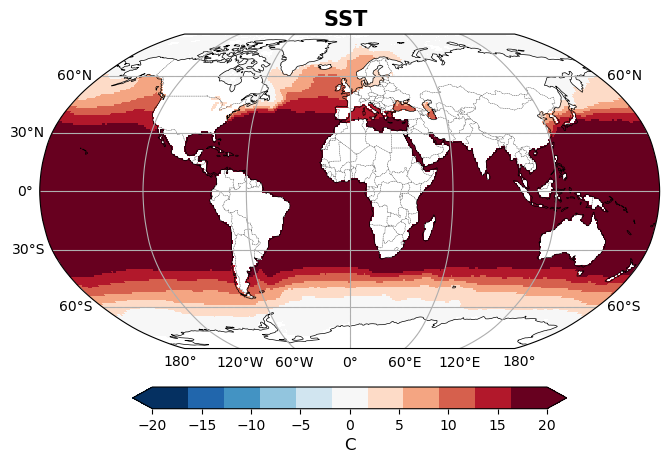

In [10]:
plotting_utils.single_plot(sst.sst.isel(time=-1),
            "SST " ,
            "RdBu_r", 11, -20, 20, 
            'C')

In [11]:
#Create Climatology (Computed Over Full Interval)
sst_gb = sst.groupby('time.month')
sst_anom = sst_gb - sst_gb.mean(dim='time') # Remove mean and create anomaly data
sst_anom = sst_anom.rename({"sst": "sst_anom"})
sst_anom = sst_anom.drop_vars('month')
sst_anom

<xarray.Dataset> Size: 383MB
Dimensions:    (time: 1478, lat: 180, lon: 360, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 12kB 1900-12-16T12:00:00 ... 2024-01-16T...
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 12kB -2.246e+04 -2.246e+04 ... 2.246e+04
    sst_anom   (time, lat, lon) float32 383MB nan nan nan nan ... nan nan nan

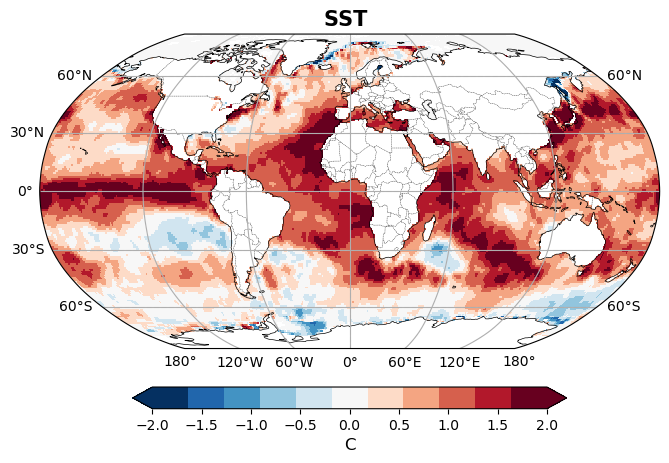

In [12]:
plotting_utils.single_plot(sst_anom.sst_anom.isel(time=-1),
            "SST " ,
            "RdBu_r", 11, -2, 2, 
            'C')

In [13]:
# # Load and clean SST dataset
# sst = xc.open_dataset(input_filepath1 + "HADI_SST_1900_2023.nc").rename({'latitude': 'lat', 'longitude': 'lon'}).bounds.add_missing_bounds()
# sst = sst.sel(time=slice('1900-12-01', '2024-01-31'))#, lat = slice(70, -70))
# sst = sst.where(sst != -1000, np.nan)  # Mask invalid values

In [ ]:
# ## Compute Climatology 

# sst_climatology = sst.temporal.climatology(
#     "sst",
#     freq="season",
#     weighted=True,
#     #reference_period = ('1981-01-01', '2010-12-31'),
#     season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
# )

In [ ]:
# ## Compute Mean Anomalies 
# sst_anomalies_no_ref = sst.temporal.departures(
#     "sst",
#     freq="season",
#     weighted=True,
#     season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
#     #reference_period = ('1981-01-01', '2010-12-31'),

# )

# sst_anomalies_no_ref 

In [ ]:
# sst_mean_anom = xr.open_dataset('data/SST_1901_2023_MEAN_ANOM.nc')
# sst_mean_anom = sst_mean_anom.sel(time =slice('1902-12-01', '2023-11-30'))
# sst_mean_anom['time'] = time_seasonal.time
# sst_mean_anom_grouped = sst_mean_anom.groupby('time.season')
# sst_mean_anom_dt = detrend_dim(sst_mean_anom.sst, 'time')

In [ ]:
# sst_seasonal = sst_mean_anom.sst
# sst_seasonal  = sst_seasonal.assign_coords(season=sst_seasonal['time'].dt.season)
# sst_seasonal

# Load HGT

In [55]:
def process_geopotential_pressure_level(z, pressure_level= None, season= None, time_range=None, lat_range=None, lon_range=None):

    g = 9.81  # gravity (m/s^2)

    # Load and preprocess dataset
    #Z = xr.open_dataset(filepath).drop_vars('number', errors='ignore')
    Z = z
    Z = Z.rename({dim: new_name for dim, new_name in {'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'}.items() if dim in Z.dims})
    Z = Z.assign_coords(time=pd.to_datetime(Z["time"].values, format="%Y%m%d"))
    Z = Z.drop_vars('expver', errors='ignore')
    Z = Z.sel(time=slice(*time_range))

    if lat_range:
        Z = Z.sel(lat=slice(*lat_range))

    # # Select variable at given pressure level and convert to geopotential height (m)
    Z_level = Z.sel(pressure_level=pressure_level)['z']
    h = Z_level / g     # Convert to geopotential height
    h_var_name = f"h_{pressure_level}"

    ds_out = xr.Dataset({
        'z': Z_level,
        h_var_name: h
    })
    
#     h_500 = process_geopotential_pressure_level(
#     z,
#     pressure_level=500,
#     time_range = ('1950-01-01', '2023-12-31'),
#     lat_range=(90, -90),
#     )

#     h_500 = h_500.bounds.add_missing_bounds()

    return ds_out

In [56]:
z = xr.open_dataset("data/HGT.nc")#.rename({'latitude': 'lat', 'longitude': 'lon'})#.bounds.add_missing_bounds()
z

<xarray.Dataset> Size: 13GB
Dimensions:         (valid_time: 1018, pressure_level: 3, latitude: 721,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-10-01
  * pressure_level  (pressure_level) float64 24B 700.0 500.0 200.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          (valid_time) <U4 16kB ...
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 13GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [68]:
h_500 = process_geopotential_pressure_level(
    z,
    pressure_level=500,
    time_range = ('1950-01-01', '2023-12-31'),
    lat_range=(90, -90),
)

h_500 = h_500.bounds.add_missing_bounds()

In [69]:
h_500_anomalies = h_500.temporal.departures(
    "h_500",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

#h_200_anomalies_seasonal = h_200_anomalies.h_200.groupby('time.season')

# single_plot_pacific_centered(sst_anomalies_seasonal['DJF'].isel(time=-1), f"SST - {sst_anomalies_seasonal['DJF'].isel(time=-1).time.values}" ,
#                "RdBu_r", 19, -2.5, 2.5, 'Anomalies')

2025-09-05 14:30:33,207 [WARNING]: temporal.py(_set_data_var_attrs:868) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2025-09-05 14:30:33,207 [WARNING]: temporal.py(_set_data_var_attrs:868) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2025-09-05 14:31:23,227 [WARNING]: temporal.py(_set_data_var_attrs:868) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, se

In [72]:
h_500_anomalies

<xarray.Dataset> Size: 2GB
Dimensions:         (lat: 721, lon: 1440, bnds: 2, time: 295)
Coordinates:
    number          int64 8B 0
    pressure_level  float64 8B 500.0
  * lat             (lat) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) object 2kB 1950-04-01 00:00:00 ... 2023-10-01 00:0...
Dimensions without coordinates: bnds
Data variables:
    lon_bnds        (lon, bnds) float64 23kB -0.125 0.125 0.125 ... 359.6 359.9
    lat_bnds        (lat, bnds) float64 12kB 90.0 89.88 89.88 ... -89.88 -90.0
    h_500           (time, lat, lon) float64 2GB -4.976 -4.976 ... 10.94 10.94

In [73]:
def anomalies_area_wgt(h_seasonal):
    # Group by season
    #h_seasonal = h.resample(time='QS-DEC').mean(dim='time', skipna=False).groupby('time.season')
    h_season = h_seasonal

    # Compute area-weighted mean
    lat_weights = np.cos(np.deg2rad(h_season['lat']))
    weights = lat_weights.broadcast_like(h_season)
    weighted_mean = (h_season * weights).sum(dim=['lat', 'lon']) / weights.sum(dim=['lat', 'lon'])

    # Compute anomalies by removing area-weighted mean
    anomalies_rm_aw = h_season - weighted_mean

    return anomalies_rm_aw

h_500_anom_rm_aw = anomalies_area_wgt(h_500_anomalies['h_500'])


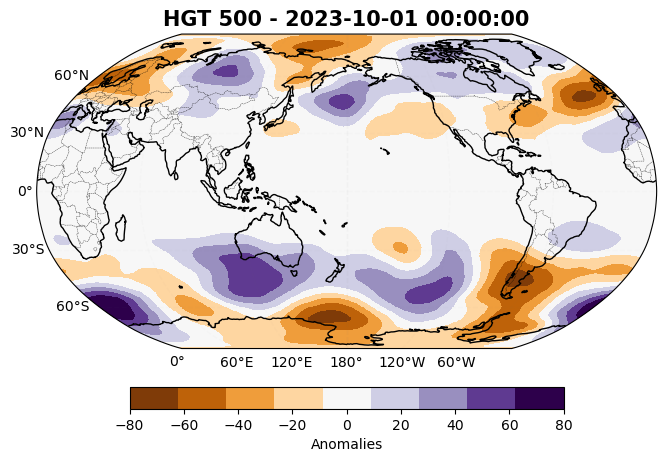

In [76]:
plotting_utils.single_plot_pacific_centered(h_500_anom_rm_aw.isel(time=-1), f"HGT 500 - {h_500_anom_rm_aw.isel(time=-1).time.values}" ,
               "PuOr", 9, -80, 80, 'Anomalies')

In [64]:
def anomalies_area(h, season):
    # Group by season
    h_seasonal = h.resample(time='QS-DEC').mean(dim='time', skipna=False).groupby('time.season')
    h_season = h_seasonal[season]

    # Compute area-weighted mean
    lat_weights = np.cos(np.deg2rad(h_season['lat']))
    weights = lat_weights.broadcast_like(h_season)
    weighted_mean = (h_season * weights).sum(dim=['lat', 'lon']) / weights.sum(dim=['lat', 'lon'])

    # Compute anomalies by removing area-weighted mean
    anomalies_rm_aw = h_season - weighted_mean

    return anomalies_rm_aw

h_500_anom_rm_aw_DJF = anomalies_area(h_500, 'DJF')
h_500_anom_rm_aw_DJF

<xarray.Dataset> Size: 1GB
Dimensions:         (lat: 721, lon: 1440, time: 75)
Coordinates:
    number          int64 8B 0
    pressure_level  float64 8B 500.0
  * lat             (lat) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon             (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 600B 1949-12-01 ... 2023-12-01
Data variables:
    z               (time, lat, lon) float64 623MB -5.932e+03 ... -5.969e+03
    h_500           (time, lat, lon) float64 623MB -604.6 -604.6 ... -608.5

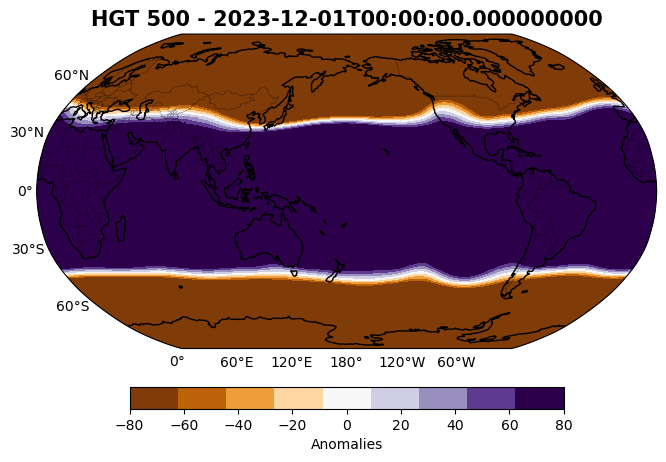

In [66]:
single_plot_pacific_centered(h_500_anom_rm_aw_DJF.h_500.isel(time=-1), f"HGT 500 - {h_500_anom_rm_aw_DJF.h_500.isel(time=-1).time.values}" ,
               "PuOr", 9, -80, 80, 'Anomalies')

# Load SLP

Allan, R. J. and Ansell, T. J. (2006) 'A new globally complete monthly historical mean sea level pressure data set (HadSLP2): 1850-2004', Journal of Climate, (accepted)

The source should also be quoted in the acknowledgements section as www.metoffice.gov.uk/hadobs.

In [54]:
slp = xr.open_dataset("data/slp.mon.mean.nc")#.rename({'latitude': 'lat', 'longitude': 'lon'})#.bounds.add_missing_bounds()
slp = slp.sel(time=slice('1900-12-01', '2024-01-31'))#, lat = slice(70, -70))
slp = slp.assign_coords(lon=((slp.lon +180) % 360) - 180).sortby('lon')

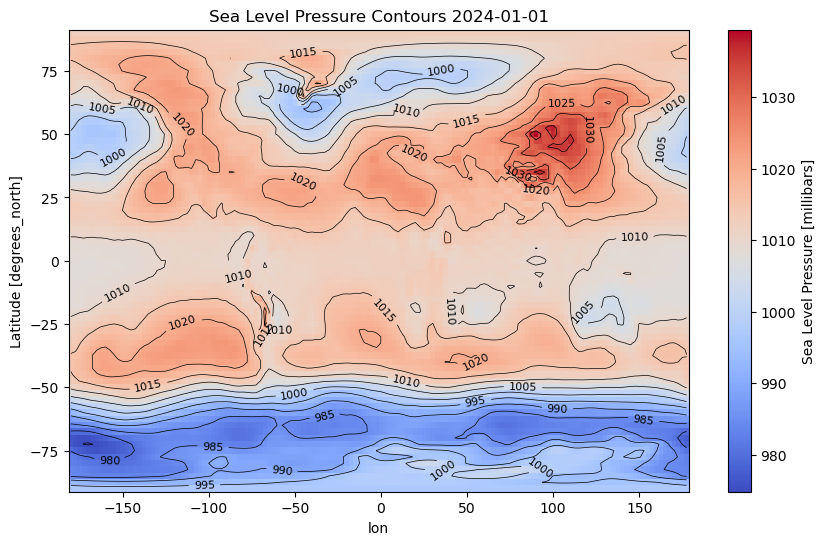

In [11]:
da = slp.slp.isel(time=-1)

# Plot filled background
fig, ax = plt.subplots(figsize=(10,6))
da.plot(ax=ax, cmap="coolwarm", add_colorbar=True)

# Add contour lines
cs = ax.contour(
    da.lon, da.lat, da,
    levels=15, colors="black", linewidths=0.5
)
ax.clabel(cs, inline=True, fontsize=8, fmt="%.0f")

ax.set_title(f"Sea Level Pressure Contours {str(da.time.values)[:10]}")
plt.show()

In [56]:
#Create Climatology
slp_gb = slp.groupby('time.month')
slp_anom = slp_gb - slp_gb.mean(dim='time') # Remove mean and create anomaly data
slp_anom = slp_anom.rename({"slp": "slp_anom"})
slp_anom = slp_anom.drop_vars('month')
slp_anom

<xarray.Dataset> Size: 38MB
Dimensions:   (lat: 73, time: 913, lon: 144)
Coordinates:
  * lat       (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * time      (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-01-01
  * lon       (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
Data variables:
    slp_anom  (time, lat, lon) float32 38MB 0.4767 0.4767 ... -3.413 -3.413

# Prepare Indexes

For each index:
- [ ] Compute index (compare with load) 
- [ ] Convert to seasonal 
- [ ] Plot PSD for each
- [ ] Filter
- [ ] Plot 
- Plot Combined
    - [ ] Short-term
    - [ ] Long-term
- Export Output

## Functions for Indexes

### Plot Index Spatial Map

In [ ]:
def plot_teleconnection_dual_projection(var, index_data, filtered_index,
                                        index_name,
                                        map_title,
                                        titles=("Regular", "Pacific-Centered", "Index Time Series"),
                                        cmap="RdBu_r",
                                        vrange=(-1, 1),
                                        discrete_bins=21,
                                        figsize=(22, 5),
                                        index_label="Nino3.4"):

    fig = plt.figure(figsize=figsize)
    cmap1 = plt.get_cmap(cmap, discrete_bins)

    # =======================
    # First Map: Regular Projection
    # =======================
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1, projection=ccrs.Robinson())
    ax1.coastlines(resolution='110m', linewidth=0.5)

    lon1, lat1 = np.meshgrid(var.lon, var.lat)
    pcm1 = ax1.pcolormesh(lon1, lat1, var,
                          cmap=cmap1,
                          vmin=vrange[0], vmax=vrange[1],
                          transform=ccrs.PlateCarree())
    
    gl1 = ax1.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    #gl1.top_labels = False
    gl1.bottom_labels = True
    gl1.left_labels = True
    #gl1.right_labels = False

    # =======================
    # Second Map: Pacific-Centered
    # =======================
    ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=1, projection=ccrs.Robinson(central_longitude=180))
    ax2.coastlines(resolution='110m', linewidth=0.5)

    if var.lon.min() < 0:
        var_pc = var.assign_coords(lon=((var.lon + 360) % 360)).sortby('lon')
    else:
        var_pc = var.copy()
    lon2, lat2 = np.meshgrid(var_pc.lon, var_pc.lat)

    pcm2 = ax2.pcolormesh(lon2, lat2, var_pc,
                          cmap=cmap1,
                          vmin=vrange[0], vmax=vrange[1],
                          transform=ccrs.PlateCarree())
    
    gl2 = ax2.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    #gl2.top_labels = False
    gl2.bottom_labels = True
    #gl2.left_labels = False
    gl2.right_labels = True
    gl2.left_labels = True

    # Shared Colorbar
    cbar_ax = fig.add_axes([0.075, 0.05, 0.35, 0.05])
    cbar = fig.colorbar(pcm1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(map_title)

    # Overall title
    plt.suptitle(index_name, fontsize=25, fontweight="bold", x=0.15, y=0.87)

    plt.tight_layout()
    plt.show()


# Computing and Loading SST Indexes

### ENSO

"ENSO is well recognized as a natural ocean–atmosphere coupled mode in the tropical Pacific (Deser et al., 2010) affecting the global climate (Newman et al., 2003). El Niño (La Niña) refers to the warming (cooling) phase of the tropical Pacific Ocean occurring every 2–7 years. Meanwhile, the anomalous warming or cooling conditions are linked to a large-scale east–west seesaw air pressure pattern referred to as the Southern Oscillation (Capotondi et al., 2015). El Niño and the Southern Oscillation are two manifestations of the ENSO phenomenon (Bjerknes, 1969). In this study, ENSO is represented by both the Niño 3.4 index and the Southern Oscillation index (SOI). The Niño 3.4 index (1870/01–2018/12, hereafter referred to as NINO) is defined as the SST anomalies in the Niño 3.4 region (5∘ N–5∘ S; 170–120∘ W) based on the HadISST1 dataset (Rayner et al., 2003). The SOI (1866/01–2017/12) is calculated from the observed standardized sea level pressure (SLP) differences between the islands of Tahiti and Darwin, Australia (Ropelewski and Jones, 1987)."

(Pan et al., 2020)

Pan, X., Wang, G., Yang, P., Wang, J., & Tsonis, A. A. (2020). On the interconnections among major climate modes and their common driving factors. Earth System Dynamics, 11(2), 525–535. https://doi.org/10.5194/esd-11-525-2020


Rayner N. A., D. E. Parker, E. B. Horton, C. K. Folland, L. V. Alexander, D. P. Rowell, E. C. Kent, A. Kaplan, Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century, J. Geophys. Res., 108 (D14), 4407, doi:10.1029/2002JD002670, 2003.

#### Compute ENSO 
 Update to same style as PDO

In [14]:
enso_index = index_utils.compute_enso(sst_anom, 
                          #time_slice_final=slice("1980-01-01", "2020-12-31"),
                          index_name="ENSO")

#enso_index = enso_roi_rolling_mean.sel(time=slice('1901-01-01', '2023-12-31'))#, lat = slice(70, -70))

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


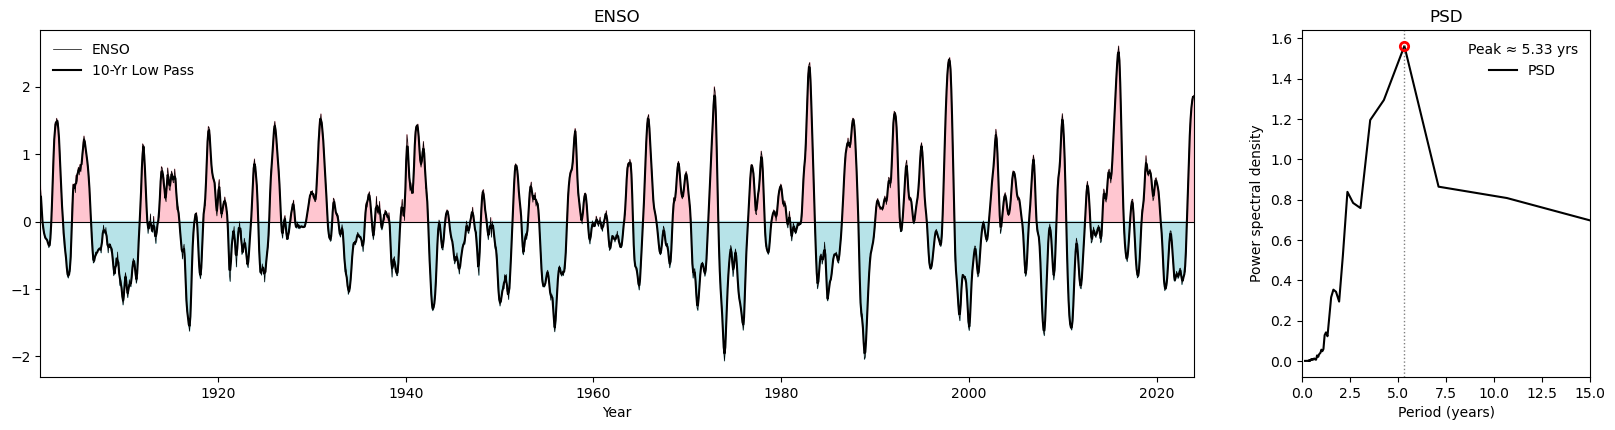

In [15]:
plotting_utils.plot_index_and_psd_combined(enso_index.ENSO, 
                          label='ENSO', 
                          smoothing=3, xlim_psd = (0, 15))

In [ ]:
# def plot_sst_with_roi(sst_anom, enso_roi, label, time_index=0, vmin=-1, vmax=1, cmap="RdBu_r"):
#     # Pick the time slice
#     sst_plot = sst_anom.sel(time=sst_anom.time[time_index])

#     # Extract ROI bounds from coords
#     lat_min, lat_max = float(enso_roi.lat.min()), float(enso_roi.lat.max())
#     lon_min, lon_max = float(enso_roi.lon.min()), float(enso_roi.lon.max())

#     # Create plot
#     fig, ax = plt.subplots(
#         1, 1, figsize=(10, 5),
#         subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
#     )
#     ax.set_global()
#     ax.coastlines()
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5)

#     # Plot SST anomalies
#     sst_plot.plot(
#         ax=ax, transform=ccrs.PlateCarree(),
#         cmap=cmap, vmin=vmin, vmax=vmax,
#         add_colorbar=True, cbar_kwargs={"label": "SST anomaly (°C)"}
#     )

#     # Draw box around ENSO ROI
#     lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
#     lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
#     ax.plot(lons, lats, transform=ccrs.PlateCarree(),
#             color="black", linewidth=2)

#     ax.set_title(f"SST anomalies with {label} ROI\n{str(sst_plot.time.values)[:10]}")
#     plt.show()

# enso_roi = sst_anom.sel(lat=slice(5, -5), lon=slice(-170, -120))
# plot_sst_with_roi(sst_anom.sst, enso_roi, time_index=0, label = "ENSO")

#### Compare Computed with Downloaded ENSO

Niño 3.4 is the area averaged anomalies over the Niño 3.4 region (5N-5S)(170-120W) using a climatology of 1981-2010. 

Downloaded From: https://psl.noaa.gov/data/timeseries/month/

In [14]:
enso_HADI = xr.open_dataset(input_filepath1 + "index/HADI_nino34.long.anom.nc") 
enso_ERSST = xr.open_dataset(input_filepath1 + "index/ERSST_nino34.long.anom.nc") 

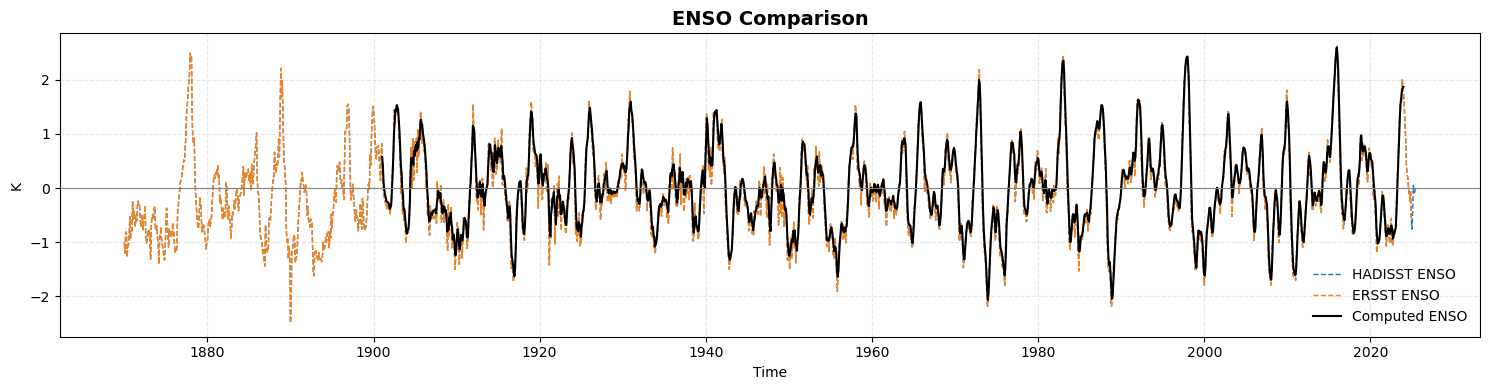

In [15]:
# Difference stems from the different climatology

plt.figure(figsize=(15, 4)) 
# Plot each ENSO time series
enso_HADI.value.plot(label="HADISST ENSO", linewidth=1, linestyle = 'dashed')
enso_ERSST.value.plot(label="ERSST ENSO", linewidth=1, linestyle = 'dashed')
enso_index.ENSO.plot(label="Computed ENSO", linewidth=1.5, color='black')

plt.axhline(0, color='gray', linewidth=0.8)
plt.title("ENSO Comparison", fontsize=14, weight='bold')
plt.xlabel("Time")
plt.ylabel("K")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

#### Compute ZScores and Plot

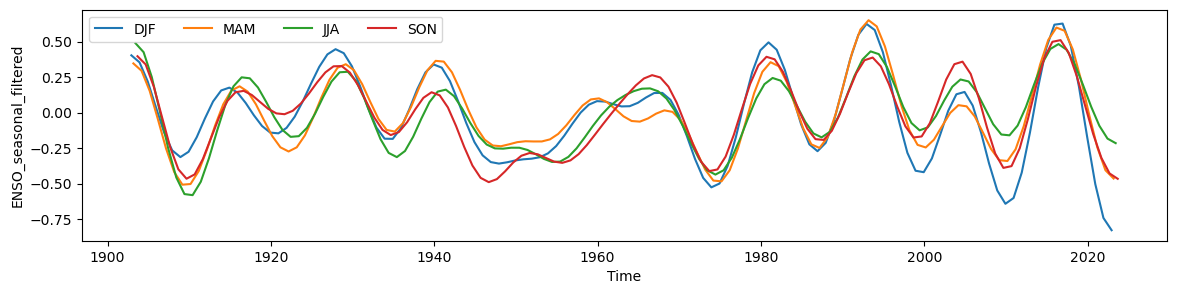

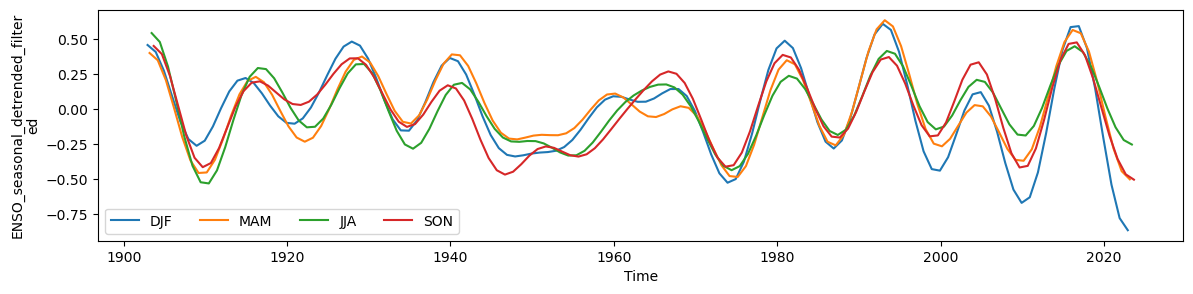

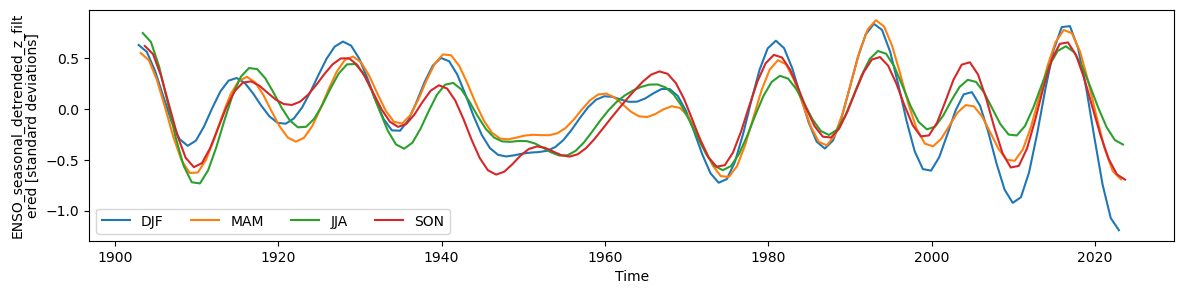

In [16]:
enso_computed_processed = index_utils.process_climate_index_w_z(enso_index, 
                      varname = "ENSO", 
                      label = "ENSO")

In [17]:
enso_seasonal_z = enso_computed_processed['seasonal_z']
enso_seasonal = enso_seasonal_z.assign_coords(season=enso_seasonal_z['time'].dt.season)

#print(list(enso_processed.keys()))

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


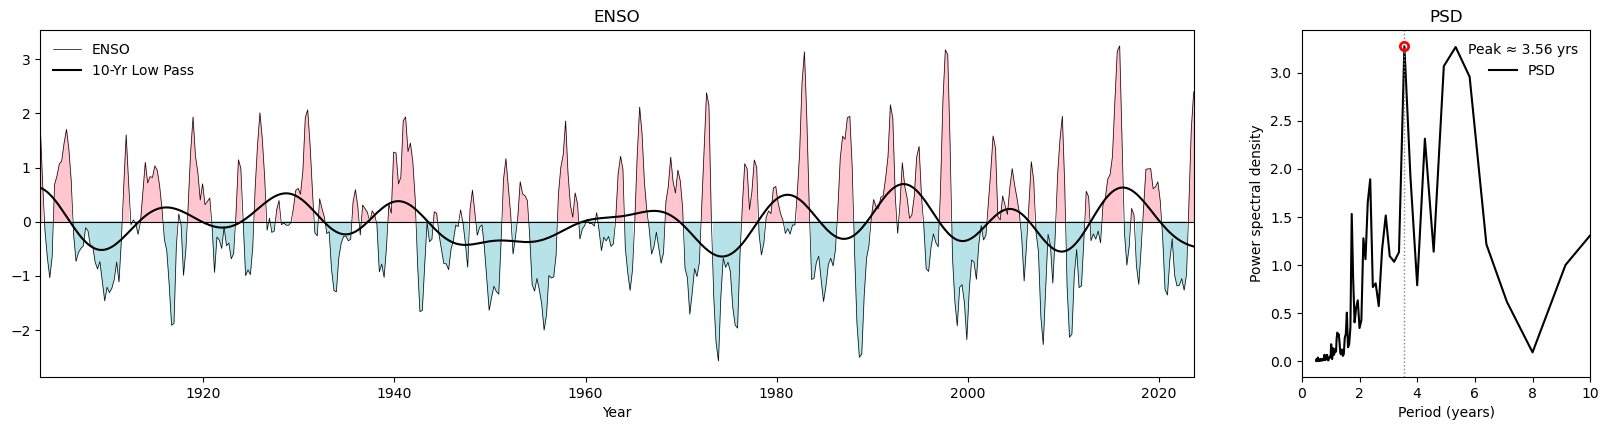

In [18]:
plotting_utils.plot_index_and_psd_combined(
    raw_data = enso_computed_processed['seasonal_dt_z'],
    filtered_data=enso_computed_processed['seasonal_dt_z_filtered'],
    label='ENSO',
    smoothing=6,
    fs=4.0,
    xlim_psd=(0, 10)  # <-- years
)

#### Spatial Maps

In [ ]:
#SST with ENSO (ZScores)
sst_seasonal_enso_corr, sst_seasonal_enso_corr_p  = linear_corr_with_p(enso_computed_processed['seasonal_dt_z'], 
                                                                       sst_mean_anom_dt, 
                                                                  enso_computed_processed['seasonal_dt_z'].time)
plot_teleconnection_dual_projection(
    var= sst_seasonal_enso_corr, 
    index_data= enso_computed_processed['seasonal_dt_z'],
    index_name = " ENSO ",
    filtered_index=enso_computed_processed['seasonal_dt_filtered'],
    titles=("ENSO", "ENSO (Pacific-Centered)", "Nino3.4 Index"),
    cmap="RdBu_r",
    vrange=(-1, 1),
    index_label="Nino3.4",
    map_title = "Correlation"
)

In [ ]:
def compute_and_plot_reg_with_corrs_p_single_season(
    idx_values: xr.DataArray,             # ENSO index for one season (1D: time)
    pdsi_season: xr.DataArray,            # PDSI anomalies (3D: time, lat, lon)
    sst_season: xr.DataArray,             # SST anomalies (3D: time, lat, lon)
    years: np.ndarray,                    # Time array
    season: str,                          # e.g., "DJF"
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst=0.5,
    overall_title="Regression with Correlation P",
    coeff_label="Regression"
):
    # Detrend
    idx_dt  = detrend_dim(idx_values, "time")
    pdsi_dt = detrend_dim(pdsi_season, "time")
    sst_dt  = detrend_dim(sst_season, "time")

    # Run regression
    reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt, years)
    reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt,  years)
    four_reg_plot_with_sig(
        [reg_pdsi], cmap_pdsi, vlim_pdsi,
        [reg_sst],  cmap_sst,  vlim_sst,
        [p_pdsi], [p_sst],
        [season],
        overall_title,
        coeff_label
    )

    return {
        'pdsi_reg': reg_pdsi,
        'sst_reg': reg_sst,
        'pdsi_pvals': p_pdsi,
        'sst_pvals': p_sst
    }

enso_reg_w_corr_p_pdsi_sst_single = compute_and_plot_reg_with_corrs_p_single_season(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season')['DJF'],
    pdsi_season =pdsi_seasonal_dt.groupby('time.season')['DJF'],
    sst_season=sst_mean_anom_dt.groupby('time.season')['DJF'],
    years=years_1903_2023,
    season=['DJF'],#,'MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO [DJF]',
    #coeff_label='Correlation Coefficient'
)

In [ ]:
enso_reg_w_corr_p_pdsi_sst_single = compute_and_plot_reg_with_corrs_p_single_season(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season')['SON'],
    pdsi_season =pdsi_seasonal_dt.groupby('time.season')['DJF'],
    sst_season=sst_mean_anom_dt.groupby('time.season')['DJF'],
    years=years_1903_2023,
    season=['DJF'],#,'MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO [DJF]',
    #coeff_label='Correlation Coefficient'
)

In [ ]:
enso_reg_w_corr_p_pdsi_sst_single = compute_and_plot_reg_with_corrs_p_single_season(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season')['DJF'],
    pdsi_season =pdsi_seasonal_dt.groupby('time.season')['MAM'],
    sst_season=sst_mean_anom_dt.groupby('time.season')['MAM'],
    years=years_1903_2023,
    season=['DJF'],#,'MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 0.5,
    overall_title='SST and PDSI \n ENSO [DJF]',
    #coeff_label='Correlation Coefficient'
)

In [ ]:
enso_reg_w_corr_p_pdsi_sst_single = compute_and_plot_reg_with_corrs_p_single_season(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season')['SON'],
    pdsi_season =pdsi_seasonal_dt.groupby('time.season')['DJF'],
    sst_season=sst_mean_anom_dt.groupby('time.season')['DJF'],
    years=years_1903_2023,
    season=['DJF'],#,'MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO [DJF]',
    #coeff_label='Correlation Coefficient'
)

#### Plot SST + Var Maps

In [ ]:
SEASON_ORDER = ["DJF", "MAM", "JJA", "SON"]

def _shift_season(season, offset):
    i = SEASON_ORDER.index(season)
    k = i + offset
    return SEASON_ORDER[k % 4], k // 4

# def detrend_dim(da, dim="time"):
#     # safe, tiny linear detrend
#     n = int(da.sizes.get(dim, 0))
#     if n < 2:
#         return da
#     tnum = xr.DataArray(np.arange(n), dims=[dim], coords={dim: da[dim]})
#     pf = da.polyfit(dim=dim, deg=1, skipna=True)
#     return (da - xr.polyval(tnum, pf.polyfit_coefficients))

# def linear_reg_with_corr_p(pc_series, field, years=None):
#     # Optionally force a specific time axis; otherwise keep as-is
#     if years is not None:
#         pc_series = pc_series.copy()
#         field = field.copy()
#         pc_series["time"] = years
#         field["time"] = years

#     # Align on time intersection (avoids different coverages)
#     pc_series, field = xr.align(pc_series, field, join="inner")

#     n = int(field.sizes.get("time", 0))
#     if n < 3:
#         # Not enough samples: return NaN maps shaped like a single time-slice
#         base = field.isel(time=0, drop=True) * np.nan
#         return base, base, base

#     dof = n - 2
#     reg  = xr.cov(field, pc_series, dim="time")
#     corr = xr.corr(field, pc_series, dim="time")
#     tval = corr * np.sqrt(dof / (1 - corr**2))
#     p = xr.apply_ufunc(lambda x: 2 * (1 - t.cdf(np.abs(x), dof)), tval)
#     return reg, corr, p

# def compute_and_plot_reg_with_corrs_p_with_lag(
#     idx_values,
#     pdsi_anoms_seasonal,
#     sst_anoms_seasonal,
#     years, seasons,
#     lag_seasons=0,      # 0, 1, 2
#     lag_years=0,        # 0 or 1 (keep simple)
#     index_leads=True,   # True: index leads → field lags
#     cmap_pdsi="BrBG", vlim_pdsi=0.5,
#     cmap_sst="RdBu_r",  vlim_sst=0.5,
#     overall_title="Regression with Correlation P",
#     coeff_label="Regression",
# ):
#     pdsi_reg_dt, sst_reg_dt = [], []
#     pdsi_pvals_dt, sst_pvals_dt = [], []
#     dual_sel_titles = []

#     for season in seasons:
#         idx_s = idx_values[season]

#         tgt_season, wrap = _shift_season(season, lag_seasons if index_leads else -lag_seasons)
#         total_shift = wrap + (lag_years if index_leads else -lag_years)

#         pdsi_s = pdsi_anoms_seasonal[tgt_season]
#         sst_s  = sst_anoms_seasonal[tgt_season]

#         # Apply lag: shift the series that LAGS
#         if index_leads and total_shift:
#             pdsi_s = pdsi_s.shift(time=-total_shift)
#             sst_s  = sst_s.shift(time=-total_shift)
#         elif (not index_leads) and total_shift:
#             idx_s  = idx_s.shift(time=-total_shift)

#         # Align on time intersection AFTER shifts
#         idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
#         idx_a, sst_a  = xr.align(idx_a, sst_s,  join="inner")

#         # If no overlap, fill NaNs so plotting still runs
#         if int(idx_a.sizes.get("time", 0)) < 3:
#             nan_pdsi = pdsi_anoms_seasonal[tgt_season].isel(time=0, drop=True) * np.nan
#             nan_sst  = sst_anoms_seasonal[tgt_season].isel(time=0, drop=True) * np.nan
#             pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
#             pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
#             dual_sel_titles.append(f"{season} (no overlap)")
#             continue

#         # Detrend
#         idx_dt  = detrend_dim(idx_a,  "time")
#         pdsi_dt = detrend_dim(pdsi_a, "time")
#         sst_dt  = detrend_dim(sst_a,  "time")

#         # Use the already-aligned time; don't force external `years`
#         reg_pdsi, corr_pdsi, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
#         reg_sst,  corr_sst,  p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

#         pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
#         pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

#         lag_txt = []
#         if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
#         if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
#         dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

#     # your existing plotter
#     four_reg_plot_with_sig(
#         pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
#         sst_reg_dt,  cmap_sst,  vlim_sst,
#         pdsi_pvals_dt, sst_pvals_dt,
#         dual_sel_titles,
#         overall_title,
#         coeff_label
#     )

#     return {
#         "pdsi_reg": pdsi_reg_dt,
#         "sst_reg":  sst_reg_dt,
#         "pdsi_pvals": pdsi_pvals_dt,
#         "sst_pvals":  sst_pvals_dt
#     }


In [ ]:
# four_reg_plot_with_sig(var = enso_reg_w_corr_p_pdsi_sst['pdsi_reg'], 
#                        var_cmap = "BrBG", 
#                        var_vval = 0.5,
#                        var_2 = enso_reg_w_corr_p_pdsi_sst['sst_reg'], 
#                        var_cmap_2 = "RdBu_r", var_vval_2 = 1,
#                        pvals1 = enso_reg_w_corr_p_pdsi_sst['pdsi_pvals'], 
#                        pvals2= enso_reg_w_corr_p_pdsi_sst['sst_pvals'],
#                         val_sel_titles = SEAS, 
#                        overall_title = 'SST and PDSI \n ENSO',
#                        var_label = "REG")

In [ ]:
def compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx: xr.DataArray,           # e.g., ENSO index (dims: time)
    pdsi: xr.DataArray,          # dims: time, lat, lon
    sst: xr.DataArray,           # dims: time, lat, lon
    seasons=("DJF", "MAM", "JJA", "SON"),
    lag_seasons=0,
    lag_years=0,
    index_leads=True,
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst=1,
    overall_title="Regression with Correlation P",
    coeff_label='Regression'
):
    # Add a season coordinate
    idx  = idx.assign_coords(season=idx['time'].dt.season)
    pdsi = pdsi.assign_coords(season=pdsi['time'].dt.season)
    sst  = sst.assign_coords(season=sst['time'].dt.season)

    # Total lag in seasons
    total_shift = lag_seasons + 4 * lag_years

    pdsi_reg_dt, sst_reg_dt = [], []
    pdsi_pvals_dt, sst_pvals_dt = [], []
    dual_sel_titles = []


    for season in seasons:
        # Select seasonal slices
        idx_s  = idx.where(idx['season'] == season, drop=True)
        pdsi_s = pdsi.where(pdsi['season'] == season, drop=True)
        sst_s  = sst.where(sst['season'] == season, drop=True)
        
        print(f"\nSeason: {season}")
        print("Index years:", idx_s['time'].values[:5])
        print("PDSI years:", pdsi_s['time'].values[:5])

        # Apply lag by shifting time
        if total_shift != 0:
            if index_leads:
                pdsi_s = pdsi_s.shift(time=-total_shift)
                sst_s  = sst_s.shift(time=-total_shift)
            else:
                idx_s = idx_s.shift(time=-total_shift)

        # Align on time after lag
        idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
        idx_a, sst_a  = xr.align(idx_a, sst_s, join="inner")
        
        print("Aligned index years:", idx_a['time'].values[:5])
        print("Aligned pdsi years:", pdsi_a['time'].values[:5])


        if idx_a.sizes['time'] < 3:
            nan_like = pdsi_s.isel(time=0, drop=True) * np.nan
            pdsi_reg_dt.append(nan_like)
            sst_reg_dt.append(nan_like)
            pdsi_pvals_dt.append(nan_like)
            sst_pvals_dt.append(nan_like)
            dual_sel_titles.append(f"{season} (no overlap)")
            continue

        # Detrend
        idx_dt  = detrend_dim(idx_a, "time")
        pdsi_dt = detrend_dim(pdsi_a, "time")
        sst_dt  = detrend_dim(sst_a, "time")

        # Regression
        reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt, idx_dt['time'])
        reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt,  idx_dt['time'])

        pdsi_reg_dt.append(reg_pdsi)
        sst_reg_dt.append(reg_sst)
        pdsi_pvals_dt.append(p_pdsi)
        sst_pvals_dt.append(p_sst)

        # Title
        lag_txt = []
        if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
        if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
        dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

    # Plot
    four_reg_plot_with_sig(
        pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
        sst_reg_dt, cmap_sst, vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        'pdsi_reg': pdsi_reg_dt,
        'sst_reg': sst_reg_dt,
        'pdsi_pvals': pdsi_pvals_dt,
        'sst_pvals': sst_pvals_dt
    }


res = compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx = enso_seasonal,
    pdsi = pdsi_seasonal,
    sst  = sst_seasonal,
    seasons=["DJF", "MAM", "JJA", "SON"],
    lag_seasons=0,
    lag_years=0,
    index_leads=True,
    overall_title="ENSO Lagged Regressions",
    coeff_label="Regression Coeff"
)

In [ ]:
res = compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx = enso_seasonal,
    pdsi = pdsi_seasonal,
    sst  = sst_seasonal,
    seasons=["DJF", "MAM", "JJA", "SON"],
    lag_seasons=1,
    lag_years=0,
    index_leads=True,
    overall_title="ENSO Lagged Regressions",
    coeff_label="Regression Coeff"
)

In [ ]:
def time_shift(da: xr.DataArray, steps: int) -> xr.DataArray:
    """
    Shift a DataArray in time, preserving the correct time coordinate.
    Only works if time dimension is uniformly spaced (like seasonal data).
    """
    shifted = da.shift(time=steps)
    if 'time' in da.coords:
        shifted['time'] = da['time']
    return shifted


def compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx: xr.DataArray,           # e.g., ENSO index (dims: time)
    pdsi: xr.DataArray,          # dims: time, lat, lon
    sst: xr.DataArray,           # dims: time, lat, lon
    seasons=("DJF", "MAM", "JJA", "SON"),
    lag_seasons=0,
    lag_years=0,
    index_leads=True,
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst=0.5,
    overall_title="Regression with Correlation P",
    coeff_label='Regression'
):
    # Tag seasons as coordinate
    idx  = idx.assign_coords(season=idx['time'].dt.season)
    pdsi = pdsi.assign_coords(season=pdsi['time'].dt.season)
    sst  = sst.assign_coords(season=sst['time'].dt.season)

    # Total shift in seasons
    total_shift = lag_seasons + 4 * lag_years

    pdsi_reg_dt, sst_reg_dt = [], []
    pdsi_pvals_dt, sst_pvals_dt = [], []
    dual_sel_titles = []

    for season in seasons:
        # 1. Slice each seasonal time series
        idx_s  = idx.where(idx['season'] == season, drop=True)
        pdsi_s = pdsi.where(pdsi['season'] == season, drop=True)
        sst_s  = sst.where(sst['season'] == season, drop=True)

        # 2. Apply lag (by shifting time and data together)
        if total_shift != 0:
            if index_leads:
                pdsi_s = time_shift(pdsi_s, -total_shift)
                sst_s  = time_shift(sst_s, -total_shift)
            else:
                idx_s = time_shift(idx_s, -total_shift)

        # 3. Align
        idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
        idx_a, sst_a  = xr.align(idx_a, sst_s, join="inner")

        # 4. Check overlap
        if idx_a.sizes['time'] < 3:
            nan_like = pdsi_s.isel(time=0, drop=True) * np.nan
            pdsi_reg_dt.append(nan_like)
            sst_reg_dt.append(nan_like)
            pdsi_pvals_dt.append(nan_like)
            sst_pvals_dt.append(nan_like)
            dual_sel_titles.append(f"{season} (no overlap)")
            continue

        # 5. Detrend
        idx_dt  = detrend_dim(idx_a, "time")
        pdsi_dt = detrend_dim(pdsi_a, "time")
        sst_dt  = detrend_dim(sst_a,  "time")

        # 6. Regress
        reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt, idx_dt['time'])
        reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt,  idx_dt['time'])

        # 7. Store results
        pdsi_reg_dt.append(reg_pdsi)
        sst_reg_dt.append(reg_sst)
        pdsi_pvals_dt.append(p_pdsi)
        sst_pvals_dt.append(p_sst)

        # 8. Title
        lag_txt = []
        if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
        if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
        dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

    # 9. Plot
    four_reg_plot_with_sig(
        pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
        sst_reg_dt,  cmap_sst,  vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        'pdsi_reg': pdsi_reg_dt,
        'sst_reg': sst_reg_dt,
        'pdsi_pvals': pdsi_pvals_dt,
        'sst_pvals': sst_pvals_dt
    }


res = compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx = enso_seasonal,
    pdsi = pdsi_seasonal,
    sst  = sst_seasonal,
    seasons=["DJF", "MAM", "JJA", "SON"],
    lag_seasons=1,
    lag_years=0,
    index_leads=True,
    overall_title="ENSO → PDSI + SST (Lagged 1 Season)",
    coeff_label="Regression Coefficient"
)

In [ ]:
res = compute_and_plot_reg_with_corrs_p_with_lag_simple(
    idx = enso_seasonal,
    pdsi = pdsi_seasonal,
    sst  = sst_seasonal,
    seasons=["DJF", "MAM", "JJA", "SON"],
    lag_seasons=1,
    lag_years=0,
    index_leads=False,
    overall_title="ENSO → PDSI + SST (Lagged 1 Season)",
    coeff_label="Regression Coefficient"
)

In [ ]:
enso_reg_w_corr_p_pdsi_sst = compute_and_plot_reg_with_corrs_p_MOV(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season'),
    pdsi_anoms_seasonal=pdsi_seasonal_dt.groupby('time.season'),
    sst_anoms_seasonal=sst_mean_anom_dt.groupby('time.season'),
    years=years_1903_2023,
    seasons=['DJF','MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO',
    #coeff_label='Correlation Coefficient'
)

In [ ]:
enso_reg_w_corr_p_pdsi_sst = compute_and_plot_reg_with_corrs_p_MOV(
    idx_values = enso_computed_processed['seasonal_dt_z'].groupby('time.season'),
    pdsi_anoms_seasonal=pdsi_seasonal_dt.groupby('time.season'),
    sst_anoms_seasonal=sst_mean_anom_dt.groupby('time.season'),
    years=years_1903_2023,
    seasons=['DJF','MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO',
    #coeff_label='Correlation Coefficient'
)

In [ ]:
def compute_and_plot_reg_with_corrs_p_with_lag(
    idx_seasonal: xr.DataArray,        # ENSO seasonal means (dims: season,time)
    pdsi_seasonal: xr.DataArray,       # PDSI seasonal means (dims: season,time,lat,lon)
    sst_seasonal: xr.DataArray,        # SST seasonal means (dims: season,time,lat,lon)
    seasons=("DJF", "MAM", "JJA", "SON"),
    lag_seasons=0,
    lag_years=0,
    index_leads=True,
    cmap_pdsi="BrBG", vlim_pdsi=0.5,
    cmap_sst="RdBu_r",  vlim_sst=0.5,
    overall_title="Regression with Correlation P",
    coeff_label="Regression",
):
    pdsi_reg_dt, sst_reg_dt = [], []
    pdsi_pvals_dt, sst_pvals_dt = [], []
    dual_sel_titles = []

    SEASON_ORDER = ["DJF","MAM","JJA","SON"]

    for season in seasons:
        # --- Select base season ---
        idx_s  = idx_seasonal.sel(season=season)
        pdsi_s = pdsi_seasonal.sel(season=season)
        sst_s  = sst_seasonal.sel(season=season)

        # --- Compute seasonal lag target ---
        base_idx = SEASON_ORDER.index(season)
        if index_leads:
            tgt_idx = base_idx + lag_seasons
        else:
            tgt_idx = base_idx - lag_seasons
        tgt_season = SEASON_ORDER[tgt_idx % 4]

        # --- Select target season from fields ---
        if index_leads:
            pdsi_s = pdsi_seasonal.sel(season=tgt_season)
            sst_s  = sst_seasonal.sel(season=tgt_season)
        else:
            idx_s  = idx_seasonal.sel(season=tgt_season)

        # --- Apply year lag (shift along time axis) ---
        if lag_years:
            shift = -lag_years if index_leads else lag_years
            pdsi_s = pdsi_s.shift(time=shift)
            sst_s  = sst_s.shift(time=shift) if index_leads else sst_s
            idx_s  = idx_s.shift(time=shift) if not index_leads else idx_s

        # --- Align ---
        idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
        idx_a, sst_a  = xr.align(idx_a, sst_s, join="inner")

        if int(idx_a.sizes.get("time",0)) < 3:
            nan_pdsi = pdsi_s.isel(time=0, drop=True) * np.nan
            nan_sst  = sst_s.isel(time=0, drop=True) * np.nan
            pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
            pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
            dual_sel_titles.append(f"{season} (no overlap)")
            continue

        # --- Detrend ---
        idx_dt  = detrend_dim(idx_a,  "time")
        pdsi_dt = detrend_dim(pdsi_a, "time")
        sst_dt  = detrend_dim(sst_a,  "time")

        # --- Regressions ---
        reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
        reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

        pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
        pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

        # --- Titles ---
        lag_txt = []
        if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
        if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
        dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

    # --- Plot ---
    four_reg_plot_with_sig(
        pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
        sst_reg_dt,  cmap_sst,  vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        "pdsi_reg": pdsi_reg_dt,
        "sst_reg":  sst_reg_dt,
        "pdsi_pvals": pdsi_pvals_dt,
        "sst_pvals":  sst_pvals_dt,
        "titles": dual_sel_titles,
    }


In [ ]:
# # Inputs: seasonal means with season dimension
# enso_seasonal = enso_monthly.groupby("time.season").mean("time")
# pdsi_seasonal = pdsi_monthly.groupby("time.season").mean("time")
# sst_seasonal  = sst_monthly.groupby("time.season").mean("time")

res = compute_and_plot_reg_with_corrs_p_with_lag(
    idx_seasonal = enso_seasonal,
    pdsi_seasonal = pdsi_seasonal,
    sst_seasonal  = sst_seasonal,
    seasons=["DJF","MAM","JJA","SON"],
    lag_seasons=1,   # shift by 1 season
    lag_years=0,
    index_leads=True
)


In [ ]:
def compute_and_plot_reg_with_corrs_p_with_lag(
    idx_seasonal: xr.DataArray,
    pdsi_seasonal: xr.DataArray,
    sst_seasonal: xr.DataArray,
    seasons=("DJF", "MAM", "JJA", "SON"),
    lag_seasons=0,
    lag_years=0,
    index_leads=True,
    cmap_pdsi="BrBG", vlim_pdsi=0.5,
    cmap_sst="RdBu_r",  vlim_sst=0.5,
    overall_title="Regression with Correlation P",
    coeff_label="Regression",
):
    pdsi_reg_dt, sst_reg_dt = [], []
    pdsi_pvals_dt, sst_pvals_dt = [], []
    dual_sel_titles = []

    SEASON_ORDER = ["DJF","MAM","JJA","SON"]

    for season in seasons:
        # --- Select base season using .where ---
        idx_s  = idx_seasonal.where(idx_seasonal['season'] == season, drop=True)
        pdsi_s = pdsi_seasonal.where(pdsi_seasonal['season'] == season, drop=True)
        sst_s  = sst_seasonal.where(sst_seasonal['season'] == season, drop=True)

        # --- Determine lag target season ---
        base_idx = SEASON_ORDER.index(season)
        tgt_idx = base_idx + lag_seasons if index_leads else base_idx - lag_seasons
        tgt_season = SEASON_ORDER[tgt_idx % 4]

        if index_leads and lag_seasons > 0:
            pdsi_s = pdsi_seasonal.where(pdsi_seasonal['season'] == tgt_season, drop=True)
            sst_s  = sst_seasonal.where(sst_seasonal['season'] == tgt_season, drop=True)
        elif (not index_leads) and lag_seasons > 0:
            idx_s  = idx_seasonal.where(idx_seasonal['season'] == tgt_season, drop=True)

        # --- Year lag along time axis ---
        if lag_years:
            shift = -lag_years if index_leads else lag_years
            if index_leads:
                pdsi_s = pdsi_s.shift(time=shift)
                sst_s  = sst_s.shift(time=shift)
            else:
                idx_s  = idx_s.shift(time=shift)

        # --- Align ---
        idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
        idx_a, sst_a  = xr.align(idx_a, sst_s, join="inner")

        if int(idx_a.sizes.get("time",0)) < 3:
            nan_pdsi = pdsi_s.isel(time=0, drop=True) * np.nan
            nan_sst  = sst_s.isel(time=0, drop=True) * np.nan
            pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
            pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
            dual_sel_titles.append(f"{season} (no overlap)")
            continue

        # --- Detrend ---
        idx_dt  = detrend_dim(idx_a,  "time")
        pdsi_dt = detrend_dim(pdsi_a, "time")
        sst_dt  = detrend_dim(sst_a,  "time")

        # --- Regressions ---
        reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
        reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

        pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
        pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

        # --- Titles ---
        lag_txt = []
        if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
        if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
        dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

    # --- Plot ---
    four_reg_plot_with_sig(
        pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
        sst_reg_dt,  cmap_sst,  vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        "pdsi_reg": pdsi_reg_dt,
        "sst_reg":  sst_reg_dt,
        "pdsi_pvals": pdsi_pvals_dt,
        "sst_pvals":  sst_pvals_dt,
        "titles": dual_sel_titles,
    }

res = compute_and_plot_reg_with_corrs_p_with_lag(
    idx_seasonal = enso_seasonal,
    pdsi_seasonal = pdsi_seasonal,
    sst_seasonal  = sst_seasonal.sst,
    seasons=["DJF","MAM","JJA","SON"],
    lag_seasons=1,   # one-season lag
    lag_years=0,
    index_leads=True
)

In [ ]:
# def compute_and_plot_reg_with_corrs_p_with_lag(
#     idx_seasonal: xr.DataArray,        # ENSO seasonal means (dims: season,time)
#     pdsi_seasonal: xr.DataArray,       # PDSI seasonal means (dims: season,time,lat,lon)
#     sst_seasonal: xr.DataArray,        # SST seasonal means (dims: season,time,lat,lon)
#     seasons=("DJF", "MAM", "JJA", "SON"),
#     lag_seasons=0,
#     lag_years=0,
#     index_leads=True,
#     cmap_pdsi="BrBG", vlim_pdsi=0.5,
#     cmap_sst="RdBu_r",  vlim_sst=0.5,
#     overall_title="Regression with Correlation P",
#     coeff_label="Regression",
# ):
#     pdsi_reg_dt, sst_reg_dt = [], []
#     pdsi_pvals_dt, sst_pvals_dt = [], []
#     dual_sel_titles = []

#     SEASON_ORDER = ["DJF","MAM","JJA","SON"]

#     for season in seasons:
#         # --- Select base season ---
#         idx_s  = idx_seasonal.sel(season=season)
#         pdsi_s = pdsi_seasonal.sel(season=season)
#         sst_s  = sst_seasonal.sel(season=season)

#         # --- Compute seasonal lag target ---
#         base_idx = SEASON_ORDER.index(season)
#         if index_leads:
#             tgt_idx = base_idx + lag_seasons
#         else:
#             tgt_idx = base_idx - lag_seasons
#         tgt_season = SEASON_ORDER[tgt_idx % 4]

#         # --- Select target season from fields ---
#         if index_leads:
#             pdsi_s = pdsi_seasonal.sel(season=tgt_season)
#             sst_s  = sst_seasonal.sel(season=tgt_season)
#         else:
#             idx_s  = idx_seasonal.sel(season=tgt_season)

#         # --- Apply year lag (shift along time axis) ---
#         if lag_years:
#             shift = -lag_years if index_leads else lag_years
#             pdsi_s = pdsi_s.shift(time=shift)
#             sst_s  = sst_s.shift(time=shift) if index_leads else sst_s
#             idx_s  = idx_s.shift(time=shift) if not index_leads else idx_s

#         # --- Align ---
#         idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
#         idx_a, sst_a  = xr.align(idx_a, sst_s, join="inner")

#         if int(idx_a.sizes.get("time",0)) < 3:
#             nan_pdsi = pdsi_s.isel(time=0, drop=True) * np.nan
#             nan_sst  = sst_s.isel(time=0, drop=True) * np.nan
#             pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
#             pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
#             dual_sel_titles.append(f"{season} (no overlap)")
#             continue

#         # --- Detrend ---
#         idx_dt  = detrend_dim(idx_a,  "time")
#         pdsi_dt = detrend_dim(pdsi_a, "time")
#         sst_dt  = detrend_dim(sst_a,  "time")

#         # --- Regressions ---
#         reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
#         reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

#         pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
#         pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

#         # --- Titles ---
#         lag_txt = []
#         if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
#         if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
#         dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

#     # --- Plot ---
#     four_reg_plot_with_sig(
#         pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
#         sst_reg_dt,  cmap_sst,  vlim_sst,
#         pdsi_pvals_dt, sst_pvals_dt,
#         dual_sel_titles,
#         overall_title,
#         coeff_label
#     )

#     return {
#         "pdsi_reg": pdsi_reg_dt,
#         "sst_reg":  sst_reg_dt,
#         "pdsi_pvals": pdsi_pvals_dt,
#         "sst_pvals":  sst_pvals_dt,
#         "titles": dual_sel_titles,
#     }


In [ ]:
# pdsi_seasonal = pdsi_seasonal.assign_coords(season=pdsi_seasonal['time'].dt.season)
# sst_seasonal  = sst_seasonal.assign_coords(season=sst_seasonal['time'].dt.season)


In [ ]:
# def compute_and_plot_reg_with_corrs_p_with_lag(
#     idx_seasonal: xr.DataArray,       # has coords time, season
#     pdsi_seasonal: xr.DataArray,
#     sst_seasonal: xr.DataArray,
#     years, seasons=("DJF", "MAM", "JJA", "SON"),
#     lag_seasons=0,
#     lag_years=0,
#     index_leads=True,
#     cmap_pdsi="BrBG", vlim_pdsi=0.5,
#     cmap_sst="RdBu_r", vlim_sst=0.5,
#     overall_title="Regression with Correlation P",
#     coeff_label="Regression",
# ):
#     pdsi_reg_dt, sst_reg_dt = [], []
#     pdsi_pvals_dt, sst_pvals_dt = [], []
#     dual_sel_titles = []

#     for season in seasons:
#         # Select seasonal slices
#         idx_s  = idx_seasonal.where(idx_seasonal["season"] == season, drop=True) 
#         pdsi_s = pdsi_seasonal.where(pdsi_seasonal["season"] == season, drop=True) 
#         sst_s  = sst_seasonal.where(sst_seasonal["season"] == season, drop=True) 

#         # --- compute total lag in units of seasons ---
#         total_shift = lag_seasons + 4 * lag_years

#         if total_shift > 0:
#             if index_leads:
#                 # index leads → shift the fields forward
#                 pdsi_s = pdsi_s.shift(time=-total_shift)
#                 sst_s  = sst_s.shift(time=-total_shift)
#             else:
#                 # field leads → shift the index forward
#                 idx_s = idx_s.shift(time=-total_shift)

#         # Align after shifting
#         idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
#         idx_a, sst_a  = xr.align(idx_a, sst_s,  join="inner")

#         if int(idx_a.sizes.get("time", 0)) < 3:
#             nan_pdsi = pdsi_s.isel(time=0, drop=True) * np.nan
#             nan_sst  = sst_s.isel(time=0, drop=True) * np.nan
#             pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
#             pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
#             dual_sel_titles.append(f"{season} (no overlap)")
#             continue

#         # Detrend
#         idx_dt  = detrend_dim(idx_a,  "time")
#         pdsi_dt = detrend_dim(pdsi_a, "time")
#         sst_dt  = detrend_dim(sst_a,  "time")

#         # Regression, correlation, p-values
#         reg_pdsi, _, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
#         reg_sst,  _, p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

#         pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
#         pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

#         # Lag text for titles
#         lag_txt = []
#         if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
#         if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
#         dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

#     # Plot
#     four_reg_plot_with_sig(
#         pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
#         sst_reg_dt,  cmap_sst,  vlim_sst,
#         pdsi_pvals_dt, sst_pvals_dt,
#         dual_sel_titles,
#         overall_title,
#         coeff_label
#     )

#     return {
#         "pdsi_reg": pdsi_reg_dt,
#         "sst_reg":  sst_reg_dt,
#         "pdsi_pvals": pdsi_pvals_dt,
#         "sst_pvals":  sst_pvals_dt,
#         "titles": dual_sel_titles,
#     }


In [ ]:
test_lag = compute_and_plot_reg_with_corrs_p_with_lag(
    idx_seasonal = enso_seasonal,
    pdsi_seasonal=pdsi_seasonal,
    sst_seasonal=sst_seasonal.sst,
    years=years_1903_2023,
    seasons=['DJF','MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n ENSO',
    lag_seasons = 1
    #coeff_label='Correlation Coefficient'
)

test_lag

#### Compute Top Years

In [ ]:
SEASON_ORDER = ["DJF", "MAM", "JJA", "SON"]

# ---------- helpers ----------
def _season_year_index(da: xr.DataArray, season: str) -> xr.DataArray:
    """Year labels for seasonal means; shift Dec to next year for DJF."""
    if "time" not in da.dims:
        raise ValueError("Expected a 'time' dimension to compute seasonal years.")
    t = da["time"]
    years = t.dt.year
    if season == "DJF":
        years = xr.where(t.dt.month == 12, years + 1, years)
    return years.rename("year")

def _to_season_map(seasonal):
    """Normalize input to {season: DataArray} from dict, GroupBy, or DA with 'season' coord."""
    if isinstance(seasonal, dict):
        return seasonal

    gb_types = tuple(getattr(xr.core.groupby, name) 
                     for name in ("DataArrayGroupBy", "DatasetGroupBy")
                     if hasattr(xr.core.groupby, name))
    if isinstance(seasonal, gb_types):
        return {str(label): da for label, da in seasonal}

    if isinstance(seasonal, xr.DataArray) and ("season" in seasonal.coords or "season" in seasonal.dims):
        out = {}
        for s in np.unique(seasonal["season"].values):
            out[str(s)] = seasonal.sel(season=s)
        return out

    raise TypeError(f"Unsupported input type for seasonal data: {type(seasonal)}")

def _yearly_values_for_season(da: xr.DataArray, season: str):
    """Return (years, values) for a season; handles monthly or already-annual inputs."""
    if "time" in da.dims:
        years = _season_year_index(da, season)
        per_year = da.groupby(years).mean("time", skipna=True)
        y = per_year["year"].values
        v = np.asarray(per_year.values, dtype=float).squeeze()
        return y, v
    elif "year" in da.dims:
        y = da["year"].values
        v = np.asarray(da.values, dtype=float).squeeze()
        return y, v
    else:
        raise ValueError(f"{season}: expected 'time' or 'year' dimension, found {da.dims}")

# ---------- main ----------
def top10_table_by_season_split(seasonal_input, top_n: int = 10, flatten: bool = False) -> pd.DataFrame:
    """
    Returns a table where:
      - Columns are pairs per season: (Season, 'Year') and (Season, 'Z')
      - Rows 1..N are the top-N years (by highest z) for each season
      - Final row is 'Top-10 avg' with the mean z of those top-N (Year left blank)

    If flatten=True, columns are strings like 'DJF_Year' and 'DJF_Z'.
    """
    season_map = _to_season_map(seasonal_input)
    seasons = [s for s in SEASON_ORDER if s in season_map] + \
              [s for s in season_map.keys() if s not in SEASON_ORDER]

    row_index = [f"{i}" for i in range(1, top_n + 1)] + ["Top-10 avg"]
    cols = []
    data = {}

    for s in seasons:
        y, v = _yearly_values_for_season(season_map[s], s)
        mask = np.isfinite(v)
        y, v = y[mask], v[mask]

        # Defaults if no valid data
        year_entries = [np.nan] * top_n + [np.nan]
        z_entries    = [np.nan] * top_n + [np.nan]

        if v.size > 0:
            order = np.argsort(v)          # ascending
            top_idx = order[-top_n:][::-1] # descending
            top_years = y[top_idx]
            top_vals  = v[top_idx]

            # Fill rows 1..N
            for i in range(min(top_n, top_vals.size)):
                year_entries[i] = int(top_years[i])
                z_entries[i]    = round(float(top_vals[i]), 3)

            # Final row: mean of top-N z
            if top_vals.size > 0:
                z_entries[-1] = round(float(np.nanmean(top_vals)), 3)

        # Add columns for this season
        if flatten:
            data[f"{s}_Year"] = year_entries
            data[f"{s}_Z"]    = z_entries
            cols.extend([f"{s}_Year", f"{s}_Z"])
        else:
            data[(s, "Year")] = year_entries
            data[(s, "Z")]    = z_entries
            cols.extend([(s, "Year"), (s, "Z")])

    # Build DataFrame
    df = pd.DataFrame(data, index=row_index)
    if not flatten:
        df.columns = pd.MultiIndex.from_tuples(cols, names=["Season", "Top 10"])
    else:
        df = df[cols]  # keep column order
    return df

# -------- usage with your object --------
seasonal_gb = enso_processed["seasonal_dt_z_grouped"]  # dict or DataArrayGroupBy
table = top10_table_by_season_split(seasonal_gb, top_n=10, flatten=False)
display(table)  # if in Jupyter


In [ ]:
def table_by_season_split(seasonal_input, n: int = 10, which: str = "top", flatten: bool = False) -> pd.DataFrame:
    """
    Build a table with two columns per season: (Season, 'Year') and (Season, 'Z').

    Rows 1..n: the top-n (which='top') or bottom-n (which='bottom') years by z.
    Last row: the avg of those n z-scores (Year left blank).

    which ∈ {'top','bottom'}
    """
    assert which in {"top", "bottom"}, "which must be 'top' or 'bottom'"

    season_map = _to_season_map(seasonal_input)
    seasons = [s for s in SEASON_ORDER if s in season_map] + \
              [s for s in season_map.keys() if s not in SEASON_ORDER]

    avg_label = f"{which.capitalize()}-{n} avg"
    row_index = [f"{i}" for i in range(1, n + 1)] + [avg_label]
    cols, data = [], {}

    for s in seasons:
        y, v = _yearly_values_for_season(season_map[s], s)
        m = np.isfinite(v)
        y, v = y[m], v[m]

        years_col = [np.nan] * n + [np.nan]
        z_col     = [np.nan] * n + [np.nan]

        if v.size:
            order = np.argsort(v)                # ascending
            idx = (order[-n:][::-1]) if which == "top" else (order[:n])  # top or bottom
            ty, tv = y[idx], v[idx]

            # For bottom, show lowest first (more negative = rank 1)
            if which == "bottom":
                # 'order[:n]' is already ascending (lowest to higher), keep as-is
                pass

            k = min(n, tv.size)
            for i in range(k):
                years_col[i] = int(ty[i])
                z_col[i]     = round(float(tv[i]), 3)

            z_col[-1] = round(float(np.nanmean(tv)), 3)

        if flatten:
            data[f"{s}_Year"] = years_col
            data[f"{s}_Z"]    = z_col
            cols.extend([f"{s}_Year", f"{s}_Z"])
        else:
            data[(s, "Year")] = years_col
            data[(s, "Z")]    = z_col
            cols.extend([(s, "Year"), (s, "Z")])

    df = pd.DataFrame(data, index=row_index)
    if not flatten:
        df.columns = pd.MultiIndex.from_tuples(cols, names=["Season", f"{which.capitalize()} {n}"])
    else:
        df = df[cols]
    return df


seasonal_gb = enso_processed["seasonal_dt_z_grouped"]

top10_tbl    = table_by_season_split(seasonal_gb, n=10, which="top",    flatten=False)
bottom10_tbl = table_by_season_split(seasonal_gb, n=10, which="bottom", flatten=False)

display(top10_tbl)
display(bottom10_tbl)


In [ ]:
table['DJF']['Year'][0:-1]

In [ ]:
enso_processed['seasonal_dt_filtered_by_each_season_grouped']['DJF'].plot()
enso_processed['seasonal_dt_filtered_by_each_season_grouped']['SON'].plot()

In [ ]:
# Extract the ENSO time series (ONI) from the dataset
oni = enso_processed['monthly']
oni.name = 'ONI'

# Compute 3-month rolling mean (ONI definition)
oni_3mo = oni.rolling(time=3, center=False).mean().dropna("time")

# Convert to DataFrame for classification
oni_df = oni_3mo.to_dataframe().reset_index()
oni_df["Year"] = oni_df["time"].dt.year
oni_df["Month"] = oni_df["time"].dt.month

# Define classification
def classify_oni_event(val):
    if val >= 0.5:
        return "El Niño"
    elif val <= -0.5:
        return "La Niña"
    else:
        return "Neutral"

oni_df["Phase"] = oni_df["ONI"].apply(classify_oni_event)

# Identify groupings of consecutive phases
oni_df["Group"] = (oni_df["Phase"] != oni_df["Phase"].shift()).cumsum()
grouped = oni_df.groupby(["Group", "Phase"])

# Filter for valid events (≥5 overlapping 3-month means)
events = grouped.filter(lambda x: len(x) >= 5 and x.name[1] in ["El Niño", "La Niña"])

# Categorize event strength
def categorize_strength(subdf):
    max_val = subdf["ONI"].abs().max()
    if max_val >= 2.0:
        return "Very Strong"
    elif max_val >= 1.5:
        return "Strong"
    elif max_val >= 1.0:
        return "Moderate"
    elif max_val >= 0.5:
        return "Weak"
    else:
        return "N/A"
# Convert the time difference manually to months using year/month deltas
def compute_months(start, end):
    return (end.year - start.year) * 12 + (end.month - start.month) + 1

event_metadata = (
    events.groupby(["Group", "Phase"])
    .apply(lambda df: pd.Series({
        "Start": df["time"].min(),
        "End": df["time"].max(),
        "Max_Anomaly": df["ONI"].max() if df["Phase"].iloc[0] == "El Niño" else df["ONI"].min(),
        "Strength": categorize_strength(df),
        "Duration_Months": compute_months(df["time"].min(), df["time"].max())
    }))
    .reset_index()
)

event_metadata

# Optional: color by category
strength_colors = {
    "El Niño": {
        "Weak": "#ff9999",
        "Moderate": "#ff4d4d",
        "Strong": "#e60000",
        "Very Strong": "#990000"
    },
    "La Niña": {
        "Weak": "#99ccff",
        "Moderate": "#3399ff",
        "Strong": "#0066cc",
        "Very Strong": "#003366"
    }
}

fig, ax = plt.subplots(figsize=(16, 3))

for i, row in event_metadata.iterrows():
    color = strength_colors[row["Phase"]][row["Strength"]]
    ax.barh(
        y=0, 
        left=row["Start"], 
        width=row["End"] - row["Start"], 
        height=0.3,
        color=color,
        #edgecolor='black',
        label=f'{row["Phase"]} {row["Strength"]}'
    )

# Clean up legend (avoid repeated labels)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Format
ax.set_yticks([])
ax.set_title("ENSO Event Timeline by Strength")
ax.set_xlabel("Year")
ax.set_xlim(event_metadata["Start"].min(), event_metadata["End"].max())
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def detect_and_plot_events(
    series,
    mode_name="ENSO",
    roll_window=3,                 # ONI uses 3-month mean
    persistence_min=5,             # ONI requires >= 5 overlapping 3-month means
    neutral_cutoff=0.5,            # phase threshold (±0.5)
    strength_bins=(0.5, 1.0, 1.5, 2.0),  # (weak_low, mod_low, strong_low, very_strong_low)
    positive_label="El Niño",      # labels for positive/negative phases
    negative_label="La Niña",
    strength_colors=None,          # optional custom palette
    title="Event Timeline by Strength",
    figsize=(16,3),
    bar_height=0.3,
    return_monthly=False
):
    """
    Replicates your ONI pipeline/plot style for any index series.

    Parameters
    ----------
    series : xr.DataArray or pd.Series with datetime index
    mode_name : str
    roll_window : int
    persistence_min : int
    neutral_cutoff : float
    strength_bins : tuple
        (weak_low, moderate_low, strong_low, very_strong_low)
        Example: (0.5, 1.0, 1.5, 2.0)
    positive_label, negative_label : str
    strength_colors : dict or None
        {
          "El Niño": {"Weak": "#ff9999", "Moderate":"#ff4d4d","Strong":"#e60000","Very Strong":"#990000"},
          "La Niña": {"Weak": "#99ccff","Moderate":"#3399ff","Strong":"#0066cc","Very Strong":"#003366"}
        }
    title : str
    figsize : tuple
    bar_height : float
    return_monthly : bool
        If True, also returns the monthly dataframe used for grouping.

    Returns
    -------
    event_metadata : pd.DataFrame
    (optional) monthly_df : pd.DataFrame when return_monthly=True
    """
    # --- Coerce to pandas Series with datetime index
    if hasattr(series, "to_series"):
        s = series.to_series()
    elif isinstance(series, pd.Series):
        s = series.copy()
    else:
        raise ValueError("series must be an xarray.DataArray or pandas.Series with a DatetimeIndex")
    s = s.sort_index()
    s.name = s.name or mode_name

    # --- Rolling mean (like ONI)
    s_roll = s.rolling(roll_window, center=False).mean().dropna()

    # --- Build monthly DF
    df = s_roll.to_frame(name=mode_name).reset_index().rename(columns={s_roll.index.name or "index":"time"})
    df["Year"] = df["time"].dt.year
    df["Month"] = df["time"].dt.month

    # --- Phase classification
    def classify_phase(v):
        if v >= neutral_cutoff:
            return positive_label
        elif v <= -neutral_cutoff:
            return negative_label
        return "Neutral"

    df["Phase"] = df[mode_name].apply(classify_phase)

    # --- Group consecutive equal phases
    df["Group"] = (df["Phase"] != df["Phase"].shift()).cumsum()
    grouped = df.groupby(["Group", "Phase"], sort=False)

    # --- Only keep target phases
    phase_keep = {positive_label, negative_label}
    events_long = grouped.filter(lambda x: x.name[1] in phase_keep)

    # --- Enforce persistence (duration in months)
    def months_len(start, end):
        return (end.year - start.year) * 12 + (end.month - start.month) + 1

    # --- Strength categorization (by absolute max during event)
    weak_low, mod_low, strong_low, vstrong_low = strength_bins
    def categorize_strength(sub):
        amax = sub[mode_name].abs().max()
        if amax >= vstrong_low:
            return "Very Strong"
        elif amax >= strong_low:
            return "Strong"
        elif amax >= mod_low:
            return "Moderate"
        elif amax >= weak_low:
            return "Weak"
        return "N/A"

    # --- Summarize events
    event_metadata = (
        events_long.groupby(["Group", "Phase"], sort=False)
        .apply(lambda d: pd.Series({
            "Start": d["time"].min(),
            "End":   d["time"].max(),
            "Max_Anomaly": d[mode_name].max() if d["Phase"].iloc[0] == positive_label else d[mode_name].min(),
            "Strength": categorize_strength(d),
            "Duration_Months": months_len(d["time"].min(), d["time"].max())
        }))
        .reset_index()
    )

    # Keep only those with required persistence
    event_metadata = event_metadata[event_metadata["Duration_Months"] >= persistence_min].copy()

    # --- Colors (match your palette by default)
    if strength_colors is None:
        strength_colors = {
            positive_label: {
                "Weak": "#ff9999", "Moderate": "#ff4d4d",
                "Strong": "#e60000", "Very Strong": "#990000"
            },
            negative_label: {
                "Weak": "#99ccff", "Moderate": "#3399ff",
                "Strong": "#0066cc", "Very Strong": "#003366"
            }
        }

    # --- Plot timeline (same style)
    fig, ax = plt.subplots(figsize=figsize)
    for _, row in event_metadata.iterrows():
        color = strength_colors[row["Phase"]].get(row["Strength"], "gray")
        ax.barh(
            y=0,
            left=row["Start"],
            width=row["End"] - row["Start"],
            height=bar_height,
            color=color,
            label=f'{row["Phase"]} {row["Strength"]}'
        )

    # Unique legend
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    if uniq:
        ax.legend(uniq.values(), uniq.keys(), bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel("Year")
    if not event_metadata.empty:
        ax.set_xlim(event_metadata["Start"].min(), event_metadata["End"].max())
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.tight_layout()
    plt.show()

    if return_monthly:
        return event_metadata.reset_index(drop=True), df
    return event_metadata.reset_index(drop=True)

# oni = enso_processed['monthly']; oni.name = 'ONI'
enso_events = detect_and_plot_events(
    enso_processed['monthly_dt'],
    mode_name="ENSO",
    roll_window=3,
    persistence_min=5,
    neutral_cutoff=0.5,
    strength_bins=(0.5, 1.0, 1.5, 2.0),
    positive_label="El Niño",
    negative_label="La Niña",
    title="ENSO Event Timeline by Strength"
)
#enso_events.head()


In [ ]:
enso_events.sortby('Max_Anomaly')

### IOD

Intensity of the IOD is represented by anomalous SST gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This gradient is named as Dipole Mode Index (DMI). When the DMI is positive then, the phenomenon is referred to as the positive IOD and when it is negative, it is referred as the negative IOD.

Possible impacts of Indian Ocean Dipole mode events on global climate. Authors: Saji, NH;Yamagata, T, CLIMATE RES, 25 (2): 151-169 DEC 5 2003.M

#### Compute IOD

In [19]:
iod_index = index_utils.compute_iod(sst_anom.sst_anom, remove_global_mean=False)
iod_index

<xarray.DataArray 'sst_anom' (time: 1478)> Size: 6kB
array([-0.46116674, -0.4195108 , -0.7327086 , ...,  1.1191359 ,
        1.0231824 ,  0.88684577], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-12-16T12:00:00 ... 2024-01-16T12...
    IOD      (time) float32 6kB -0.4612 -0.4195 -0.7327 ... 1.119 1.023 0.8868
Attributes:
    long_name:  Dipole Mode Index (West - East SST)
    units:      °C (anomaly)
    source:     Computed from SST anomalies

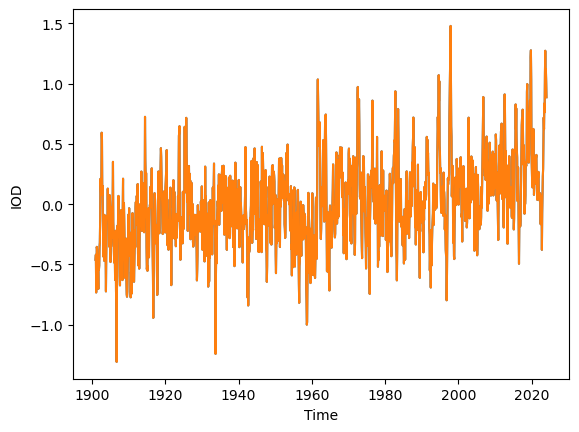

In [20]:
iod_gw = index_utils.compute_iod(sst_anom.sst_anom, remove_global_mean=False)
iod_gwa = index_utils.compute_iod(sst_anom.sst_anom, remove_global_mean=True)
iod_gwa.IOD.plot()
iod_gw.IOD.plot()

In [21]:
# # Define the West and East boxes
# west_box = sst_anom['sst_anom'].sel(lon=slice(50, 70),  lat=slice(10, -10))
# east_box = sst_anom['sst_anom'].sel(lon=slice(90,110),  lat=slice(0,  -10))
# west = west_box.mean(['lon', 'lat'])   # was -10..10
# east = east_box.mean(['lon', 'lat'])   # was -10..0
# iod_index = west - east
# iod_index['IOD'] = iod_index

# iod_index.IOD.plot()

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


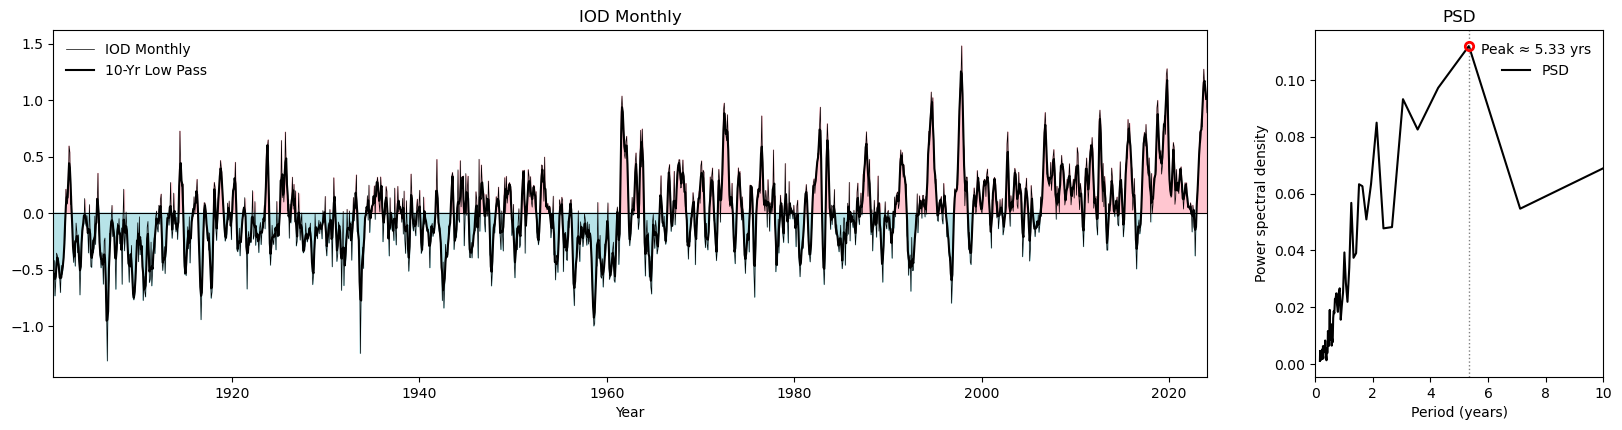

In [22]:
plotting_utils.plot_index_and_psd_combined(iod_index.IOD, 
                          label='IOD Monthly', 
                          smoothing=3, xlim_psd = (0, 10))

In [ ]:
#from cartopy import ccrs
def plot_sst_with_iod_rois(sst_anom, west_box, east_box, time_index=0, vmin=-2, vmax=2, cmap="RdBu_r"):
    sst_plot = sst_anom.isel(time=time_index)

    # Extract ROI bounds
    boxes = {"West": west_box, "East": east_box}
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5),
                           subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Plot SST anomalies
    sst_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                  vmin=vmin, vmax=vmax,
                  add_colorbar=True, cbar_kwargs={"label": "SST anomaly (°C)"})

    # Draw boxes
    for name, box in boxes.items():
        lat_min, lat_max = float(box.lat.min()), float(box.lat.max())
        lon_min, lon_max = float(box.lon.min()), float(box.lon.max())
        lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
        lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
        ax.plot(lons, lats, transform=ccrs.PlateCarree(), linewidth=2,
                label=f"{name} Box")
    
    ax.set_title(f"SST anomalies with IOD boxes\n{str(sst_plot.time.values)[:10]}")
    ax.legend()
    plt.show()

# Plot map with both boxes
plot_sst_with_iod_rois(sst_anom.sst_anom, west_box, east_box, time_index=-1)


#### Compare with Downloaded IOD

Intensity of the IOD is represented by anomalous SST gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This gradient is named as Dipole Mode Index (DMI). When the DMI is positive then, the phenomenon is referred to as the positive IOD and when it is negative, it is referred as the negative IOD.

Data Source: 
https://psl.noaa.gov/data/timeseries/month/DMI/

Input data for the mode calculation is the HadISST1.1 Dataset.

Temporal Coverage
Monthly values: 1870/01 to near present
Update Status: Monthly
Data Notes
Units: degC

References
Possible impacts of Indian Ocean Dipole mode events on global climate. Authors: Saji, NH;Yamagata, T, CLIMATE RES, 25 (2): 151-169 DEC 5 2003.M

In [24]:
dmi = xr.open_dataset(input_filepath1 + "index/dmi.had.long.nc")#.value.sel(time = slice('1901-01-01', '2023-12-31'))

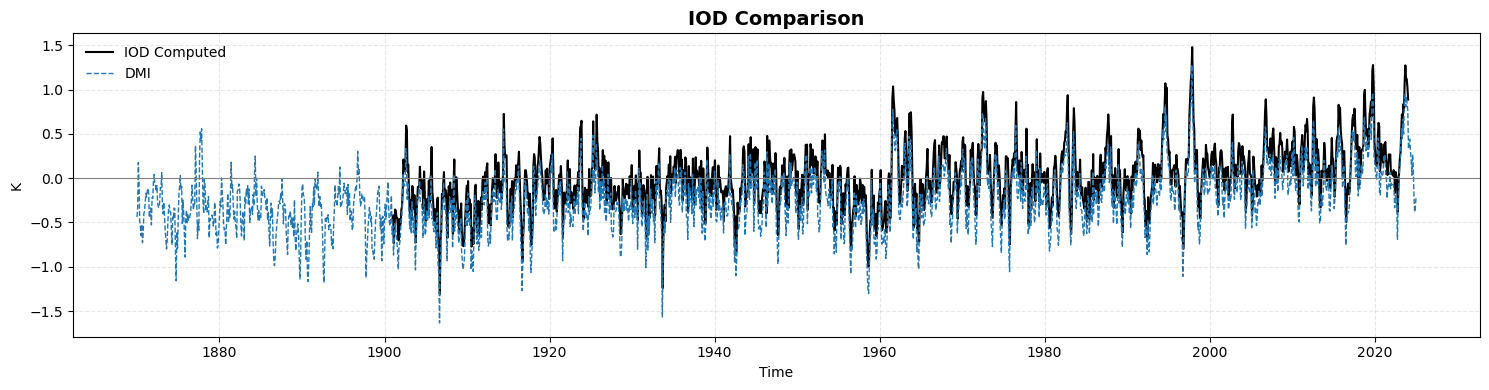

In [26]:
# Difference stems from the different climatology (??)

plt.figure(figsize=(15, 4)) 
# Plot each ENSO time series
iod_index.IOD.plot(label = 'IOD Computed', linewidth=1.5, color = 'k')#, linestyle = 'dashed')
dmi.value.plot(label = "DMI", linewidth=1, linestyle = 'dashed')
#iod_gw.IOD.plot(label = 'IOD Computed (GW)', linewidth=1.5, linestyle = 'dashed')

plt.axhline(0, color='gray', linewidth=0.8)
plt.title("IOD Comparison", fontsize=14, weight='bold')
plt.xlabel("Time")
plt.ylabel("K")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

#### Compute Zscore and Plot

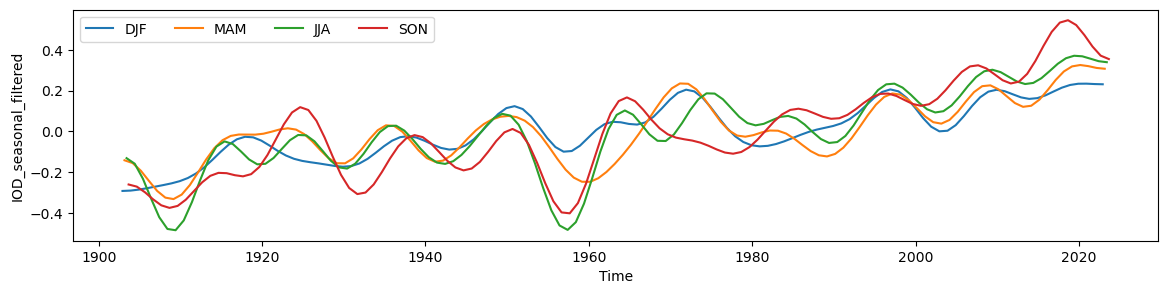

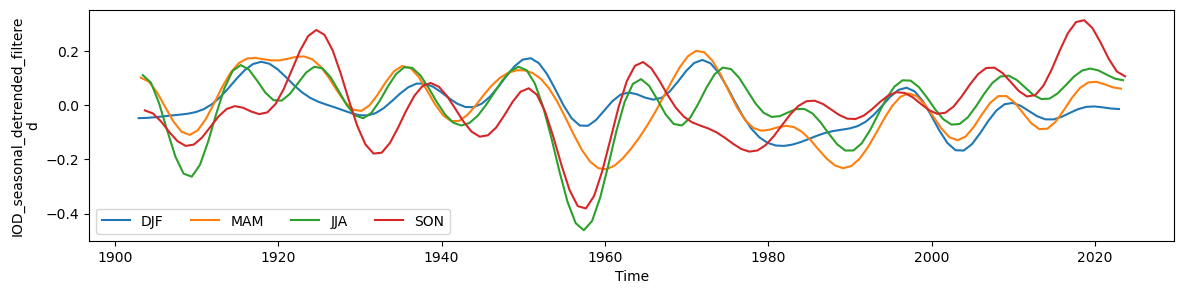

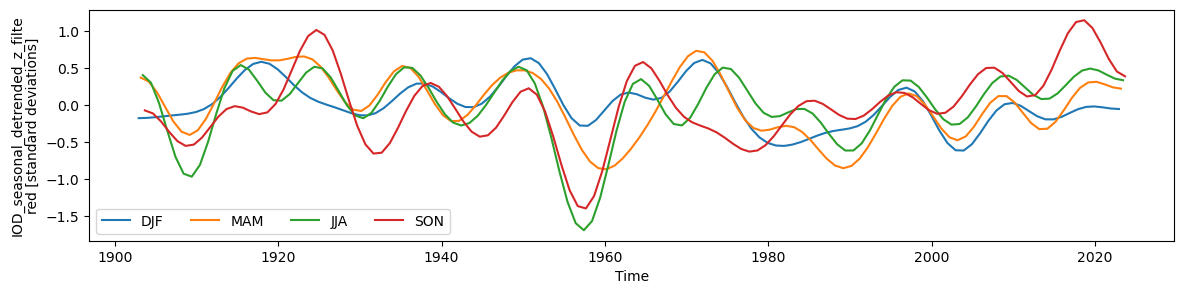

In [23]:
iod_computed_processed = index_utils.process_climate_index_w_z(iod_index, 
                      varname = "IOD", 
                      label = "IOD")
#print(list(iod_computed_processed.keys()))

In [32]:
iod_computed_processed['seasonal_dt_z'].time.min()

<xarray.DataArray 'time' ()> Size: 8B
array('1902-12-01T00:00:00.000000000', dtype='datetime64[ns]')

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


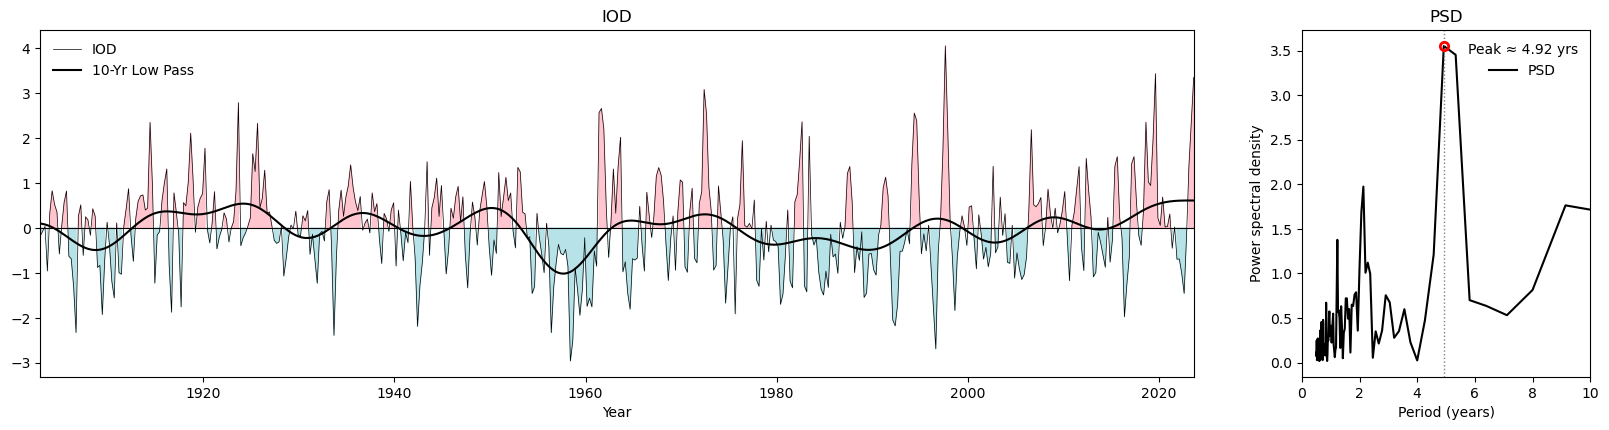

In [24]:
plotting_utils.plot_index_and_psd_combined(
    iod_computed_processed['seasonal_dt_z'],
    filtered_data=iod_computed_processed['seasonal_dt_z_filtered'],
    label='IOD',
    smoothing=6,
    fs=4.0,
    xlim_psd=(0, 10)
)


#### Spatial Maps

In [ ]:
#SST with IOD (ZScores)

sst_seasonal_iod_corr, sst_seasonal_iod_corr_p  = linear_corr_with_p(iod_computed_processed['seasonal_dt_z'], 
                                                                       sst_mean_anom_dt, 
                                                                  iod_computed_processed['seasonal_dt_z'].time)
plot_teleconnection_dual_projection(
    var= sst_seasonal_iod_corr, 
    index_data= iod_computed_processed['seasonal_dt_z'],
    index_name = "IOD (Seasonal + Index Detrended)",
    filtered_index=iod_computed_processed['seasonal_dt_filtered'],
    titles=("IOD", "IOD (Pacific-Centered)", "IOD"),
    cmap="RdBu_r",
    vrange=(-1, 1),
    index_label="IOD",
    map_title = "Correlation"
)

#### Plot SST + Var

In [ ]:
iod_reg_w_corr_p_pdsi_sst = compute_and_plot_reg_with_corrs_p_MOV(
    idx_values = iod_computed_processed['seasonal_dt_z'].groupby('time.season'),
    pdsi_anoms_seasonal=pdsi_seasonal_dt.groupby('time.season'),
    sst_anoms_seasonal=sst_mean_anom_dt.groupby('time.season'),
    years=years_1903_2023,
    seasons=['DJF','MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n IOD',
    #coeff_label='Correlation Coefficient'
)

### PDO

"PDO is the dominant pattern of decadal variability in North Pacific SST, which has been widely studied across different disciplines (Newman et al., 2016). A previous study shows that the changing phase of PDO affects the anomalies of atmospheric circulation around the North Pacific Ocean basin and even the Southern Hemisphere (Mantua and Hare, 2002). The characteristic period of PDO is 50–60 years, and a warm or cold phase of PDO can typically persist for about 20–30 years. If PDO is in its positive phase, the North Pacific Ocean turns colder and the Middle East Pacific Ocean turns warmer; otherwise, it is in a negative phase. In this study, PDO is defined by the leading principal component of monthly SST anomalies in the Pacific basin (poleward of 20∘ N) during 1900–2017 (Mantua et al., 1997)."

(Pan et al., 2020)

Pan, X., Wang, G., Yang, P., Wang, J., & Tsonis, A. A. (2020). On the interconnections among major climate modes and their common driving factors. Earth System Dynamics, 11(2), 525–535. https://doi.org/10.5194/esd-11-525-2020

#### Compute PDO

In [25]:
pdo_index, pdo_pattern, frac = index_utils.compute_pdo(sst_anom.sst_anom)#, remove_global_mean=True,
pdo_index

<xarray.DataArray 'PDO' (time: 1478)> Size: 12kB
array([ 1.519256  ,  0.78103364,  1.20939404, ..., -0.59616569,
       -0.72360571, -0.44829369])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-12-16T12:00:00 ... 2024-01-16T12...
    PDO      (time) float64 12kB 1.519 0.781 1.209 ... -0.5962 -0.7236 -0.4483
Attributes:
    units:    std. dev.
    note:     PC1 of North Pacific SST anomalies (Mantua-style)

In [42]:
pdo_index2, pdo_pattern2, frac2 = index_utils.compute_pdo(sst_anom.sst_anom, remove_global_mean=False)
pdo_index2

<xarray.DataArray 'PDO' (time: 1478)> Size: 12kB
array([-1.34230261, -0.85872038, -0.40172668, ...,  3.03552098,
        2.9518938 ,  2.43240698])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-12-16T12:00:00 ... 2024-01-16T12...
    PDO      (time) float64 12kB -1.342 -0.8587 -0.4017 ... 3.036 2.952 2.432
Attributes:
    units:    std. dev.
    note:     PC1 of North Pacific SST anomalies (Mantua-style)

#### Compare with PDO Index

Newman, M., M. A. Alexander, T. R. Ault, K. M. Cobb, C. Deser, E. Di Lorenzo, N. Mantua, A. J. Miller, S. Minobe, H. Nakamura, N. Schneider, D. J. Vimont, A. S. Phillips, J. D. Scott and C. A. Smith (June 2016): The Pacific Decadal Oscillation, Revisited. J. Climate, 29 (12), 4399-4427, https://doi.org/10.1175/JCLI-D-15-0508.1.

In [44]:
pdo_hadi = xr.open_dataset(input_filepath1 + "index/pdo.timeseries.hadisst1-1.nc").pdo.sel(time = slice('1901-01-01', '2023-12-31'))

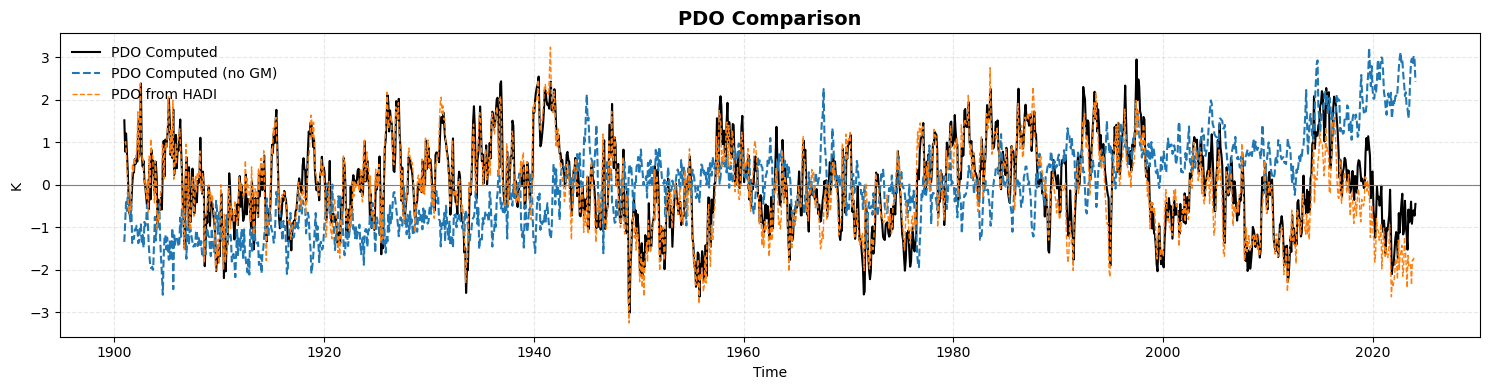

In [45]:
# Difference stems from the different climatology PDO - Climatology is 1920-2014.

plt.figure(figsize=(15, 4)) 
pdo_index.PDO.plot(label = 'PDO Computed', linewidth=1.5, color = 'k')#, linestyle = 'dashed')
pdo_index2.PDO.plot(label = 'PDO Computed (no GM)', linewidth=1.5, linestyle = 'dashed')

pdo_hadi.plot(label = "PDO from HADI", linewidth=1, linestyle = 'dashed')

plt.axhline(0, color='gray', linewidth=0.8)
plt.title("PDO Comparison", fontsize=14, weight='bold')
plt.xlabel("Time")
plt.ylabel("K")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

#### Compute Z Scores and Plot

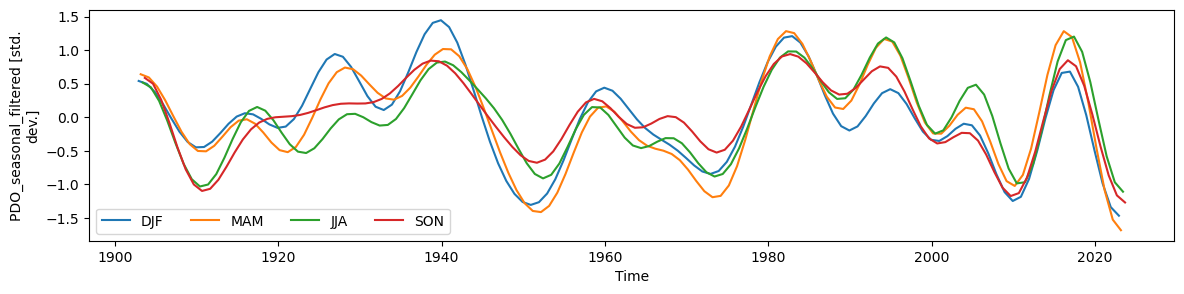

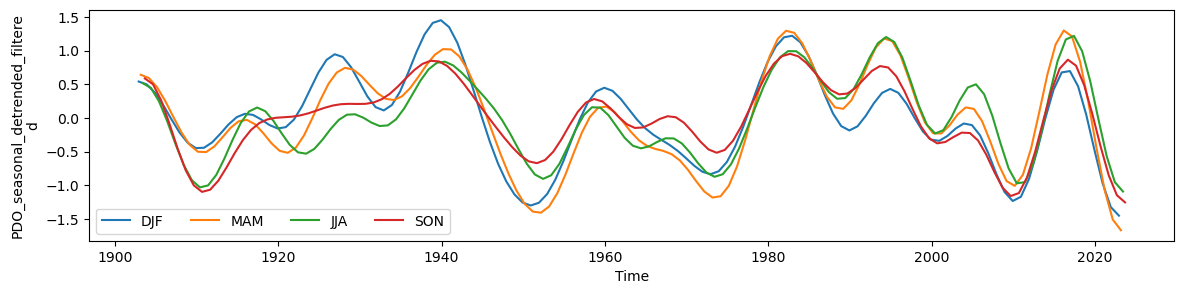

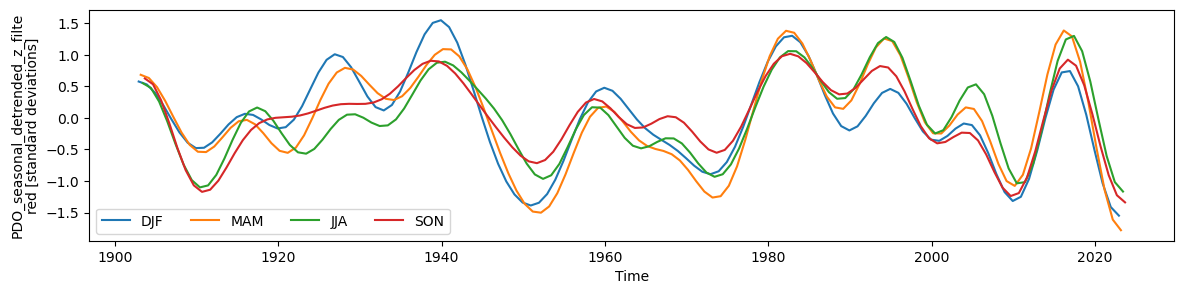

In [26]:
pdo_computed_processed = index_utils.process_climate_index_w_z(pdo_index,
                      varname = "PDO", 
                      label = "PDO")
#print(list(pdo_processed.keys()))

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


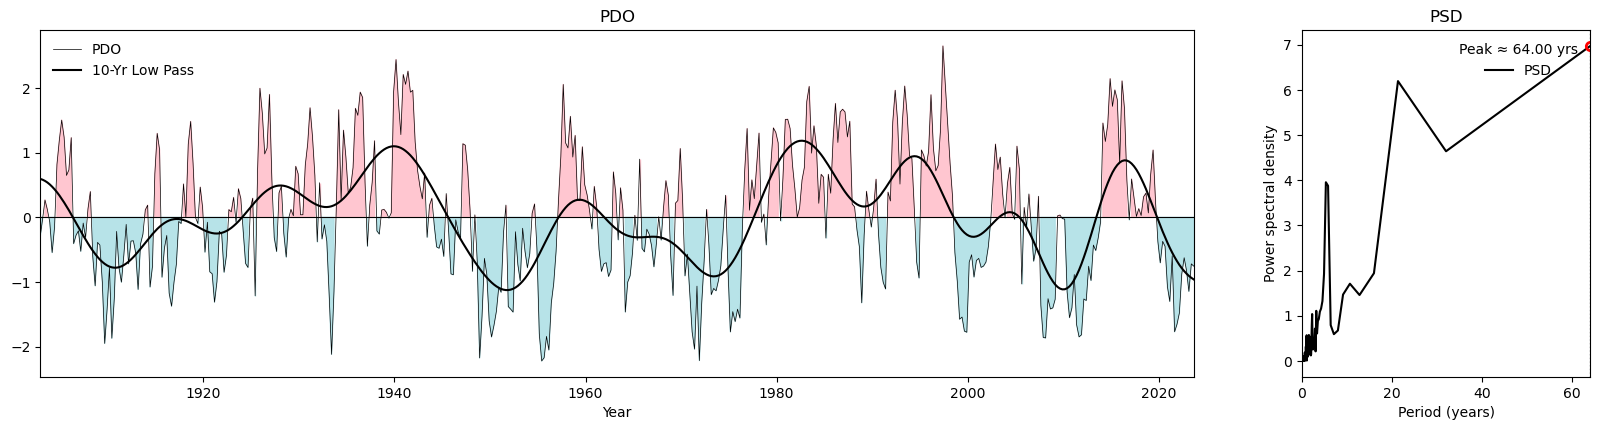

In [27]:
plotting_utils.plot_index_and_psd_combined(
    pdo_computed_processed['seasonal_dt_z'],
    filtered_data=pdo_computed_processed['seasonal_dt_z_filtered'],
    label='PDO',
    smoothing=6,
    fs=4.0,
    xlim_psd=(0, 64)  # <-- years
)


#### Spatial Map

In [ ]:
#SST with PDO (ZScores)

sst_seasonal_pdo_corr, sst_seasonal_pdo_corr_p  = linear_corr_with_p(pdo_computed_processed['seasonal_dt_z'], 
                                                                       sst_mean_anom_dt, 
                                                                  pdo_computed_processed['seasonal_dt_z'].time)
plot_teleconnection_dual_projection(
    var= sst_seasonal_pdo_corr, 
    index_data= pdo_computed_processed['seasonal_dt_z'],
    index_name = "PDO (Seasonal + Index Detrended)",
    filtered_index=pdo_computed_processed['seasonal_dt_filtered'],
    titles=("PDO", "PDO (Pacific-Centered)", "PDO"),
    cmap="RdBu_r",
    vrange=(-1, 1),
    index_label="PDO",
    map_title = "Correlation"
)

#### Plot SST + Vars

##### SST + PDSI

In [ ]:
pdo_reg_w_corr_p_pdsi_sst = compute_and_plot_reg_with_corrs_p_MOV(
    idx_values = pdo_computed_processed['seasonal_dt_z'].groupby('time.season'),
    pdsi_anoms_seasonal=pdsi_seasonal_dt.groupby('time.season'),
    sst_anoms_seasonal=sst_mean_anom_dt.groupby('time.season'),
    years=years_1903_2023,
    seasons=['DJF','MAM','JJA','SON'],
    cmap_pdsi='BrBG', vlim_pdsi=0.5,
    cmap_sst='RdBu_r', vlim_sst= 1,
    overall_title='SST and PDSI \n PDO',
    #coeff_label='Correlation Coefficient'
)

### AMO

AMO is a dominant signal of climate variability in the North Atlantic SST, which has a statistically significant spectral peak in the 50–70-year band (Schlesinger and Ramankutty, 1994; Sun et al., 2015). Related studies have suggested that AMO is an inner variability of the climate system modulating hemispheric climate change (Zhang, 2007; Knight et al., 2006). The slow variation of the Atlantic meridional overturning circulation (AMOC) plays a dominant role in the Atlantic multidecadal variability of SST (Zhang, 2017; Delworth and Mann, 2000; Garuba et al., 2018). The AMO is defined by the detrended area-weighted average SST over the North Atlantic (from 0 to 70∘ N) during 1856–2018 based on the Kaplan SST dataset (Enfield et al., 2001). Both unsmoothed and smoothed AMO indexes are available. The high-frequency variability of the smoothed AMO index has been removed by a common 121-month filter. We choose to use the unsmoothed AMO index in this study.

(Pan et al., 2020)

Pan, X., Wang, G., Yang, P., Wang, J., & Tsonis, A. A. (2020). On the interconnections among major climate modes and their common driving factors. Earth System Dynamics, 11(2), 525–535. https://doi.org/10.5194/esd-11-525-2020

#### Compute AMO 

In [ ]:
# def compute_amo(
#     sst_anom,
#     na_lat=(0., 60.), na_lon=(-80., 0.),
#     remove_global_mean=True,
#     standardize=False           # return standardized index (mean 0, std 1) if True
# ):
#     """
#     Compute AMO index:
#       1) North Atlantic mean (0–60N, 80W–0) with cos(lat) weights
#       2) Optionally subtract global mean anomaly (area-weighted) each month

#     Returns
#     -------
#     amo_mon : xr.DataArray (time)  # monthly AMO (unsmoothed)
#     amo_smooth : xr.DataArray (time) or None  # smoothed AMO (if smooth>1)
#     """
    
#     anom = sst_anom

#     # 2) North Atlantic box mean (0–60N, 80W–0), area-weighted
#     na = _box(anom, na_lat[0], na_lat[1], na_lon[0], na_lon[1])
#     w_na = np.cos(np.deg2rad(na.lat))
#     na_mean = na.weighted(w_na).mean(dim=('lat', 'lon'), skipna=True)

#     # 3) Optionally subtract global mean anomaly (area-weighted)
#     if remove_global_mean:
#         w_glob = np.cos(np.deg2rad(anom.lat))
#         gmean = anom.weighted(w_glob).mean(dim=('lat', 'lon'), skipna=True)
#         amo_mon = na_mean - gmean
#     else:
#         amo_mon = na_mean

#     # Drop auxiliary groupby coord if present
#     try:
#         amo_mon = amo_mon.reset_coords('month', drop=True)
#     except Exception:
#         pass

#     # (Optional) standardize
#     if standardize:
#         amo_mon = (amo_mon - amo_mon.mean('time')) / amo_mon.std('time', ddof=1)
#         amo_mon.attrs['units'] = 'std dev'
#     else:
#         amo_mon.attrs['units'] = '°C'

#     amo_mon.name = 'AMO'
#     amo_mon.attrs.update({
#         'long_name': 'Atlantic Multidecadal Oscillation (North Atlantic minus global mean)',
#         'region': 'North Atlantic 0–60°N, 80°W–0°',
#         'area_weighting': 'cos(lat)',
#         'global_mean_removed': bool(remove_global_mean),
#     })

#     return amo_mon



In [28]:
amo_index = index_utils.compute_amo(
    sst_anom.sst_anom,
    na_lat=(0., 60.), na_lon=(-80., 0.),
    remove_global_mean=True,
    standardize=False
)

amo_index#['AMO'] = amo_index

<xarray.DataArray 'AMO' (time: 1478)> Size: 6kB
array([-0.04774329, -0.12550333,  0.2138195 , ...,  0.25570363,
        0.20829684,  0.26230627], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-12-16T12:00:00 ... 2024-01-16T12...
    AMO      (time) float32 6kB -0.04774 -0.1255 0.2138 ... 0.2557 0.2083 0.2623
Attributes:
    units:                °C
    long_name:            Atlantic Multidecadal Oscillation (North Atlantic m...
    region:               North Atlantic 0–60°N, 80°W–0°
    area_weighting:       cos(lat)
    global_mean_removed:  True

In [ ]:
amo_index_2 = index_utils.compute_amo(
    sst_anom.sst_anom,
    na_lat=(0., 60.), na_lon=(-80., 0.),
    remove_global_mean=True,
    #smooth=121,          # NOAA-style
    standardize=False
)

#### Process AMO

Downloaded from: https://psl.noaa.gov/data/timeseries/AMO/

DIfference between computed and processed: Processed uses 1950-1980 Climatology + global mean is not removed in

Uses Kaplan SST

In [30]:
amo = xr.open_dataset(input_filepath1 + "index/AMO.nc").AMO.sel(time = slice('1901-01-01', '2023-12-30'))

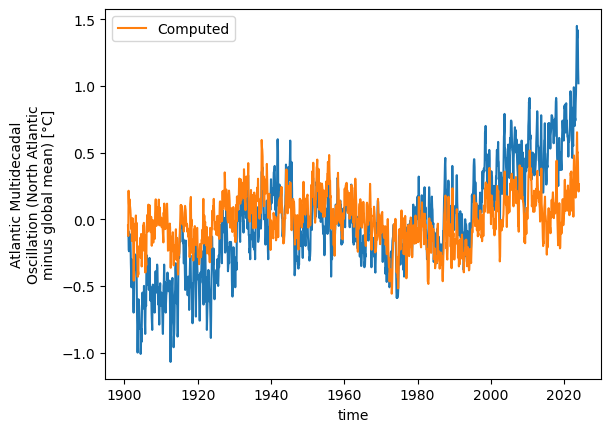

In [31]:
amo.plot()
#amo_index_2.plot(label = 'Computed (Without Global Mean Removed)')
amo_index.plot(label = 'Computed')
plt.legend()

#### Compute Z Scores and Plot

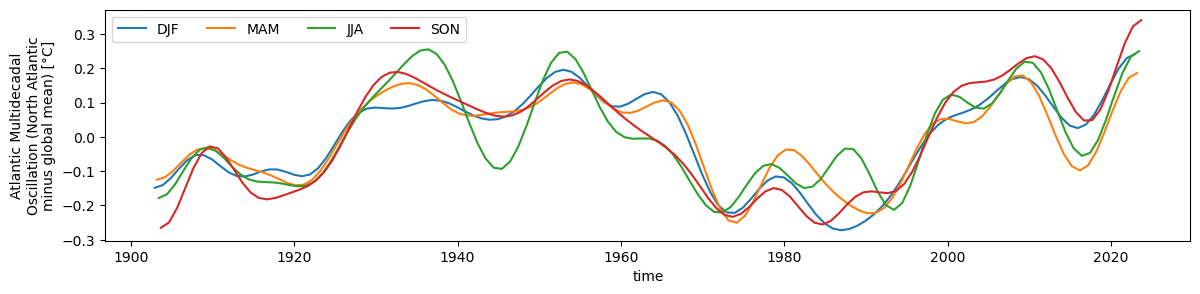

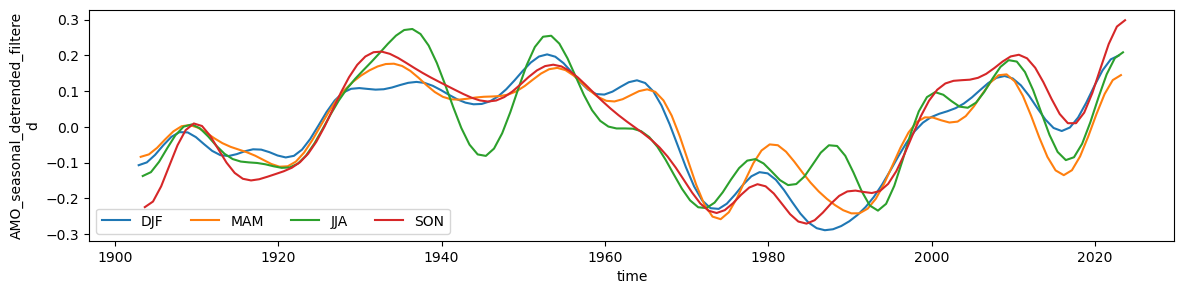

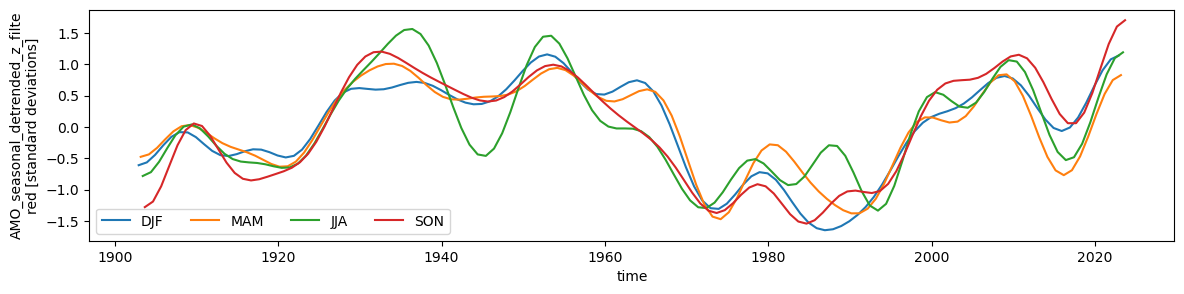

/home/andish/Global_Drivers_Drought/Scripts/plotting_utils.py:165: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs == 0, np.inf, 1.0 / freqs)


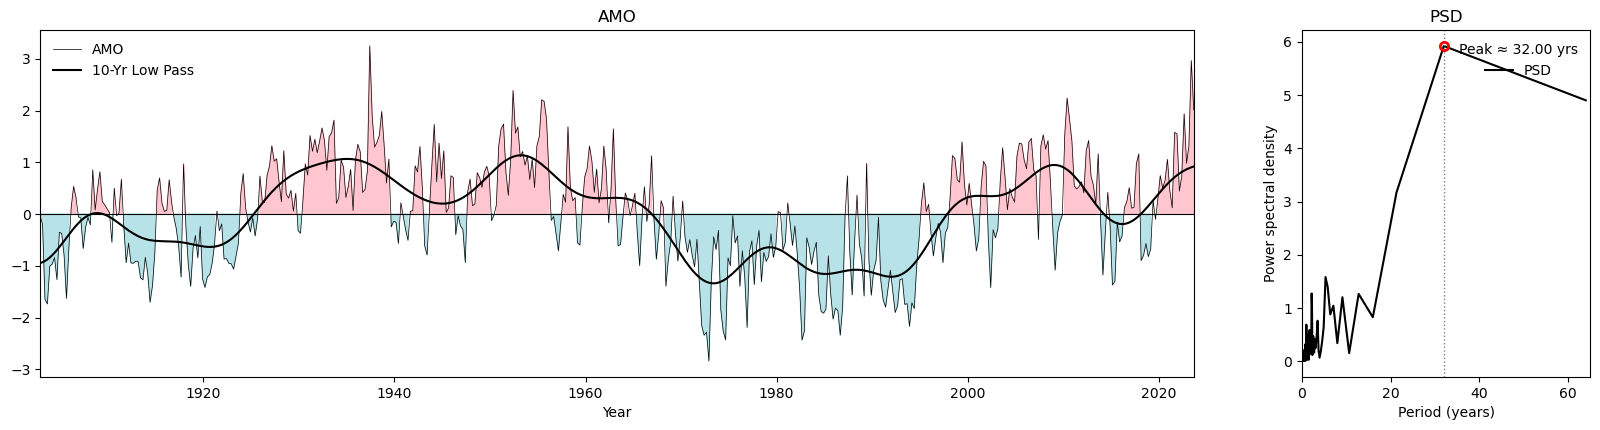

In [32]:
amo_computed_processed = index_utils.process_climate_index_w_z(amo_index,
                      varname = "AMO", 
                      label = "AMO")

plotting_utils.plot_index_and_psd_combined(
    amo_computed_processed['seasonal_dt_z'],
    filtered_data=amo_computed_processed['seasonal_dt_z_filtered'],
    label='AMO',
    smoothing=6,
    fs=4.0,
    xlim_psd=(0, 65)  # <-- years
)


In [ ]:
#SST with AMO (ZScores)

sst_seasonal_amo_corr, sst_seasonal_amo_corr_p  = linear_corr_with_p(amo_computed_processed['seasonal_dt_z'], 
                                                                       sst_mean_anom_dt, 
                                                                  amo_computed_processed['seasonal_dt_z'].time)
plot_teleconnection_dual_projection(
    var= sst_seasonal_amo_corr, 
    index_data= amo_computed_processed['seasonal_dt_z'],
    index_name = "AMO (Seasonal + Index Detrended)",
    filtered_index=amo_computed_processed['seasonal_dt_filtered'],
    titles=("AMO", "PDO (Pacific-Centered)", "AMO"),
    cmap="RdBu_r",
    vrange=(-1, 1),
    index_label="AMO",
    map_title = "Correlation"
)

#### Plot SST + Vars

### TPI 

Henley, B.J., Gergis, J., Karoly, D.J., Power, S.B., Kennedy, J., & Folland, C.K. (2015). A Tripole Index for the Interdecadal Pacific Oscillation. Climate Dynamics, 45(11-12), 3077-3090.http://dx.doi.org/10.1007/s00382-015-2525-1 . Accessed on MM DD YYYY at "/data/timeseries/IPOTPI".


Ref: 
https://link.springer.com/article/10.1007/s00382-015-2525-1

data: https://psl.noaa.gov/data/timeseries/IPOTPI/

In [ ]:
#tpi = xr.open_dataset(input_filepath1 + "index/tpi_index_monthly.nc").TPI_index.sortby("time") 
tpi_processed = process_climate_index(filepath = (input_filepath1 + "index/tpi_index_monthly.nc"), 
                      varname = "TPI_index", 
                      label = "TPI")
print(list(tpi_processed.keys()))

In [ ]:
plot_index_and_psd_combined(
    tpi_processed['monthly_dt'], 
    filtered_data=tpi_processed['monthly_dt_filtered'],
    label='TPI', smoothing=6, fs=12.0, xlim_psd=(0,0.5)
)
plt.show()

plot_index_and_psd_combined(
    tpi_processed['seasonal_dt'],
    filtered_data=tpi_processed['seasonal_dt_filtered'],
    label='TPI [Seasonal, Detrended, Filtered]', smoothing=6, fs=4.0, xlim_psd=(0,0.5)
)
plt.show()

#### OLD

In [ ]:
# Load and sort by time
tpi = xr.open_dataset(input_filepath1 + "index/tpi_index_monthly.nc").TPI_index.sortby("time") 
tpi = tpi.sel(time=slice('1901-01-01', '2023-12-30'))

# Plot original index
plot_index(tpi, label='TPI Index 1901–2023', smoothing=6)

# Detrend
tpi_detrended = xr.DataArray(
    detrend(tpi, type='linear'),
    coords=tpi.coords,
    dims=tpi.dims,
    name='TPI_detrended'
)

# Resample to seasonal
tpi_detrended_seasonal = tpi_detrended.resample(time='QS-DEC').mean(dim='time', skipna=False)

# Plot detrended
plot_index(tpi_detrended, label='TPI Index 1901–2023 [Detrended]')


## Plot all SST Indexes

In [40]:
sst_seasonal_indices_z_.to_netcdf("sst_seasonal_indices_z.nc")


TypeError: illegal data type for attribute b'global_mean_removed', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got b1

In [38]:
enso_seasonal_z_ = enso_computed_processed['seasonal_z']
iod_seasonal_z_ = iod_computed_processed['seasonal_z']
pdo_seasonal_z_ = pdo_computed_processed['seasonal_z']
amo_seasonal_z_ = amo_computed_processed['seasonal_z']

# Combine all seasonal standardized indices into one dataset
sst_seasonal_indices_z_ = xr.Dataset({
    'ENSO': enso_seasonal_z_,
    'IOD': iod_seasonal_z_,
    'PDO': pdo_seasonal_z_,
    'AMO': amo_seasonal_z_
})

# Optional: Add metadata
sst_seasonal_indices_z_.attrs["description"] = "Standardized seasonal (z-score) indices of ENSO, IOD, PDO, AMO"
sst_seasonal_indices_z_.attrs["note"] = "Each variable is grouped by time.season"

sst_seasonal_indices_z_.to_netcdf("sst_seasonal_indices_z.nc")

# Save to NetCDF
#sst_seasonal_indices_z.to_netcdf("seasonal_indices_z.nc")


TypeError: illegal data type for attribute b'global_mean_removed', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got b1

In [36]:
enso_seasonal_z = enso_computed_processed['seasonal_dt_z']
iod_seasonal_z = iod_computed_processed['seasonal_dt_z']
pdo_seasonal_z = pdo_computed_processed['seasonal_dt_z']
amo_seasonal_z = amo_computed_processed['seasonal_dt_z']

# Combine all seasonal standardized indices into one dataset
sst_seasonal_indices_z = xr.Dataset({
    'ENSO': enso_seasonal_z,
    'IOD': iod_seasonal_z,
    'PDO': pdo_seasonal_z,
    'AMO': amo_seasonal_z
})

# Optional: Add metadata
sst_seasonal_indices_z.attrs["description"] = "Standardized seasonal (z-score) indices of ENSO, IOD, PDO, AMO"
sst_seasonal_indices_z.attrs["note"] = "Each variable is grouped by time.season"

sst_seasonal_indices_z.to_netcdf("sst_seasonal_indices_dt_z.nc")

# Save to NetCDF
#sst_seasonal_indices_z.to_netcdf("seasonal_indices_z.nc")


In [35]:
# # Convert any boolean attributes to strings or integers for NetCDF compatibility
# for var in sst_seasonal_indices_z.data_vars:
#     for attr_key, attr_val in sst_seasonal_indices_z[var].attrs.items():
#         if isinstance(attr_val, bool):
#             sst_seasonal_indices_z[var].attrs[attr_key] = str(attr_val)

# # Also check and convert global attributes
# for attr_key, attr_val in sst_seasonal_indices_z.attrs.items():
#     if isinstance(attr_val, bool):
#         sst_seasonal_indices_z.attrs[attr_key] = str(attr_val)

# Now save safely to NetCDF
sst_seasonal_indices_z.to_netcdf("sst_seasonal_indices_z.nc")


In [ ]:
def compute_and_plot_corrs_MOV(idx_values,
                           pdsi_anoms_seasonal, 
                           sst_anoms_seasonal,
                           years, seasons,
                           cmap_pdsi='BrBG', vlim_pdsi=0.5,
                           cmap_sst='RdBu_r', vlim_sst=0.5,
                           overall_title = "Correlation",
                           coeff_label='Correlation'):

    pdsi_corrs_dt = []
    sst_corrs_dt = []
    pdsi_pvals_dt = []
    sst_pvals_dt = []
    dual_sel_titles = []

    for season in seasons:
        # Get and detrend index values for this seaason
        #idx_values = index_results[index_key_prefix_1][season][level_idx][index_key_prefix_2 + season]

        # Correlation with PDSI
        r_pdsi, p_pdsi = linear_corr_with_p(
            detrend_dim(idx_values[season], 'time'),
            detrend_dim(pdsi_anoms_seasonal[season], 'time'),
            years
        )

        # Correlation with SST
        r_sst, p_sst = linear_corr_with_p(
            detrend_dim(idx_values[season], 'time'),
            detrend_dim(sst_anoms_seasonal[season], 'time'),
            years
        )

        pdsi_corrs_dt.append(r_pdsi)
        sst_corrs_dt.append(r_sst)
        pdsi_pvals_dt.append(p_pdsi)
        sst_pvals_dt.append(p_sst)

        # Title for subplot
        #title = f"SST {season} Correlated and PDSI {season}\n with PDSI {season} {index_key_prefix[:-1]}"
        title = f"{season}"
        dual_sel_titles.append(title)

    # Plot
    four_reg_plot_with_sig(
        pdsi_corrs_dt, cmap_pdsi, vlim_pdsi,
        sst_corrs_dt, cmap_sst, vlim_sst,
        pdsi_pvals_dt, sst_pvals_dt,
        dual_sel_titles,
        overall_title,
        coeff_label
    )

    return {
        'pdsi_corrs': pdsi_corrs_dt,
        'sst_corrs': sst_corrs_dt,
        'pdsi_pvals': pdsi_pvals_dt,
        'sst_pvals': sst_pvals_dt
    }


## Loading HGT indexes
NAO, SNAO, PNA

### NAO
#### (NEED TO ADD SUMMER NAO) 

In [58]:
nao_index, eof1 = index_utils.compute_nao(slp_anom.slp_anom)

In [59]:
nao_index

<xarray.DataArray 'NAO' (time: 913)> Size: 7kB
array([ 4.87336428e-01, -1.58866282e-01, -1.89828041e+00, -6.43651286e-01,
        2.28116659e-01,  3.17744914e-01,  3.61989940e-01,  2.13474791e-01,
       -1.71907690e-01, -8.22850404e-01, -1.96068804e-01,  1.50228610e-01,
       -1.04082799e+00, -2.05110009e+00,  2.02012381e-01, -1.17197057e+00,
        3.15363285e-01,  4.64363778e-01,  2.47104921e-01,  4.45093188e-02,
        4.62990722e-01, -4.48173726e-01,  4.59226334e-01, -3.72643359e-01,
        1.80094163e-01, -5.26973587e-01, -3.10912710e-01, -5.49936020e-01,
        4.04757003e-01, -4.10305799e-01,  7.14824304e-01,  2.00209686e-01,
       -6.27198099e-01, -1.78469564e-01,  8.49181073e-01,  1.52633484e+00,
        1.16819115e-01,  1.76364524e-01,  2.26774300e+00,  4.85706507e-01,
        7.48969303e-01,  9.01223961e-01, -4.21071566e-01, -1.49426386e-02,
        4.90611721e-01,  7.93004465e-02,  3.82799867e-01, -1.63802276e+00,
       -6.64458301e-01,  1.41724076e+00,  2.38631600e+00, -6.23333630e-01,
        1.16251531e+00, -1.95709611e-01, -3.61757013e-01,  1.35482198e-01,
        3.34724974e-01,  4.13713423e-01,  1.20197706e+00,  1.31684943e+00,
        6.75942679e-02,  1.38769752e-01, -4.73722851e-01,  1.11501991e+00,
        4.49754343e-01, -1.96408519e-03, -3.88935602e-01, -2.34947443e-01,
       -7.65119940e-02, -4.98102920e-01, -1.32091803e+00, -7.75410648e-01,
        2.03192892e-01, -3.43135373e-02,  3.95148364e-01, -6.61754906e-01,
        1.15719694e+00, -2.24573935e-01, -2.03656724e-01,  3.69037066e-01,
...
        1.00084622e-01, -7.51541892e-01,  1.60075179e-01, -5.79970763e-01,
       -7.64032028e-01, -2.93957991e-01,  2.25169445e+00, -4.25731338e-01,
       -1.44132630e+00, -3.84528165e-01, -5.61425433e-01, -9.05081590e-01,
       -5.65209481e-01, -4.96390796e-01,  1.13748383e+00, -1.53500832e-01,
        2.07991570e-01, -2.91794861e-01, -2.15845391e+00,  2.08290072e-01,
        1.15643882e+00,  8.25036730e-01,  8.33223530e-01,  4.29385433e-01,
       -1.82773113e-01,  7.98838624e-01,  9.94835992e-01, -3.89532387e-01,
       -1.98847690e+00, -2.74695018e+00, -9.61445540e-01,  9.83970268e-02,
       -2.97881564e-01,  3.19007683e-01,  6.20132626e-03,  1.05795629e-01,
       -6.70462716e-01,  1.24131537e-01, -1.83267006e+00,  7.07878116e-01,
        2.18787418e+00,  8.41270634e-01, -1.25038501e+00,  1.10043814e+00,
        2.00336444e-01, -7.88980689e-01, -2.58230493e-01, -7.13444093e-05,
        2.15166767e-01,  4.29682589e-01,  8.03993103e-02,  3.53473085e-01,
       -1.55244964e+00, -2.42180985e+00, -5.75037211e-01,  8.65325682e-01,
       -7.18540984e-01, -1.82848069e-01, -2.95235911e-01, -3.05066014e-02,
        7.74516525e-01, -8.67119779e-01, -1.43731673e-01,  2.64139623e+00,
       -5.64763447e-01, -1.49829104e+00,  1.96586851e+00,  1.07266358e+00,
       -8.39949405e-01,  7.02327733e-01,  3.83073235e-01,  4.78007583e-01,
        2.37161747e-01,  8.03837554e-01,  5.95987770e-01, -5.32064625e-02,
       -9.59257295e-02])
Coordinates:
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-01-01
Attributes:
    units:    std. dev.
    note:     PC1 of North Atlantic SLP anomalies (PC-based NAO)

In [ ]:
# plotting_utils.plot_index_and_psd_combined(iod_index.IOD, 
#                           label='IOD Monthly', 
#                           smoothing=3, xlim_psd = (0, 10))

In [ ]:
# import xarray as xr
# import numpy as np

# # assumes your existing _box() helper

# def _lat_weights(lat, mode="sqrtcos"):
#     """
#     Return latitude weights as a 1D DataArray over 'lat'.
#     mode: 'sqrtcos' (default), 'cos', or 'none'
#     """
#     if mode in (None, "none", False):
#         return xr.ones_like(lat)
#     coslat = np.cos(np.deg2rad(lat))
#     coslat = xr.DataArray(coslat, coords={"lat": lat}, dims=("lat",))
#     if mode == "cos":
#         return coslat.clip(min=0)
#     # default: sqrtcos
#     return np.sqrt(coslat).clip(min=0)

# def compute_nao(
#     slp_anom,                     # SLP anomalies (time, lat, lon)
#     atl_lat=(20., 80.),           # 20–80°N
#     atl_lon=(-90., 40.),          # 90°W to 40°E
#     standardize_spatial=False,    # like your PDO option
#     enforce_sign=True,
#     area_weighting=True,          # <<< NEW: toggle area weighting
#     weight_mode="sqrtcos",        # 'sqrtcos' (EOF-style), 'cos', or 'none'
# ):
#     """
#     NAO as PC1 of North Atlantic SLP anomalies (PDO-style EOF workflow).

#     Returns
#     -------
#     nao : xr.DataArray (time)  -- standardized PC1 (unit variance), name='NAO'
#     eof1: xr.DataArray (lat,lon) -- leading EOF pattern, name='NAO_EOF1'
#     """
#     anom = slp_anom

#     # North Atlantic domain
#     dom = _box(anom, atl_lat[0], atl_lat[1], atl_lon[0], atl_lon[1])

#     # Weights for EOFs
#     w = _lat_weights(dom.lat, mode=weight_mode) if area_weighting else xr.ones_like(dom.lat)
#     dom_w = dom * w

#     # Keep only complete columns
#     X = dom_w.stack(space=("lat", "lon"))
#     valid = np.isfinite(X).all("time")
#     X = X[:, valid]

#     # Standardization across time per column (optional)
#     if standardize_spatial:
#         std = X.std("time", skipna=True)
#         std = xr.where(std == 0, np.nan, std)
#         X = X / std

#     # Demean over time
#     X = X - X.mean("time", skipna=True)

#     # SVD → PC1 (NAO) and EOF1
#     X_np = np.asarray(X.values, float)
#     U, svals, VT = np.linalg.svd(X_np, full_matrices=False)

#     pc1 = U[:, 0] * svals[0]
#     pc1 = (pc1 - pc1.mean()) / pc1.std(ddof=1)  # unit variance
#     eof1_space = VT[0, :]

#     # EOF back on grid
#     eof_full = xr.full_like(dom.isel(time=0), np.nan).stack(space=("lat", "lon"))
#     eof_full.loc[dict(space=X.space.values)] = eof1_space

#     # undo standardization & weights
#     if standardize_spatial:
#         eof_full = eof_full * std
#     W_full = (w * xr.ones_like(dom.isel(time=0))).stack(space=("lat", "lon"))
#     eof_full = (eof_full / W_full).unstack("space")

#     # Enforce canonical NAO sign using Iceland vs Azores boxes
#     if enforce_sign:
#         az = _box(eof_full, 36, 40, -35, -20).mean().item()   # Azores
#         ic = _box(eof_full, 60, 70, -30, -15).mean().item()   # Iceland
#         if np.isfinite(az) and np.isfinite(ic) and (ic - az) < 0:
#             pc1 = -pc1
#             eof_full = -eof_full

#     nao = xr.DataArray(
#         pc1, coords={"time": dom.time}, dims="time", name="NAO",
#         attrs={"units": "std. dev.", "note": "PC1 of North Atlantic SLP anomalies (PC-based NAO)"}
#     )
#     eof_full.name = "NAO_EOF1"
#     eof_full.attrs["note"] = "Leading EOF pattern of North Atlantic SLP anomalies"
#     return nao, eof_full

# nao_index, eof1 = compute_nao(slp_anom.slp)

#### Processed NAO 

[https://pastglobalchanges.org/publications/pages-magazines/pages-magazine/10526]
When using the NAO data, cite "Updated from Jones et al. (1997)". Main reference to cite when using this NAO index:

Jones, P.D., Jónsson, T. and Wheeler, D., 1997: Extension to the North Atlantic Oscillation using early instrumental pressure observations from Gibraltar and South-West Iceland. Int. J. Climatol. 17, 1433-1450. doi: 10.1002/(SICI)1097-0088(19971115)17:13<1433::AID-JOC203>3.0.CO;2-P

In [62]:
#nao_azores = xr.open_dataset(input_filepath1 + "index/nao_index_monthly.nc")
nao_hurrell = xr.open_dataset(input_filepath1 + "index/nao_hurrell_monthly.nc")

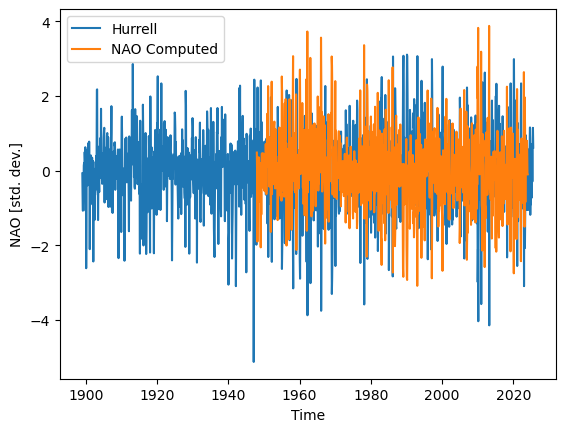

In [63]:
#nao_azores.NAO_index.plot(label = "Azores")
nao_hurrell.nao.plot(label = "Hurrell")
#nao_azores.NAO_index.plot(label = "Azores")
nao_index.plot(label = "NAO Computed")

#plt.xlim(nao_index.time.min(), nao_index.time.max())
plt.legend()

In [ ]:
plt.figure(figsize=(15, 4)) 

nao_hurrell.NAO_index.plot(label = "Hurrel", linestyle = '--')
nao_azores.NAO_index.plot(label = "Azores", linestyle = 'dashed')

#nao_index.plot(label = "NAO Computed")

#plt.xlim(nao_index.time.min(), nao_index.time.max())
plt.legend()

In [ ]:
nao_processed = process_climate_index_w_z(filepath = (input_filepath1 + "index/nao_index_monthly.nc"), 
                      varname = "NAO_index", 
                      label = "NAO")
print(list(nao_processed.keys()))

In [ ]:
plot_index_and_psd_combined(
    nao_processed['monthly'], filtered_data=None, 
    label='NAO', smoothing=6, fs=12.0, xlim_psd=(0,2)
)
plt.show()

plot_index_and_psd_combined(
    nao_processed['seasonal_dt'], filtered_data=nao_processed['seasonal_dt_filtered'], 
    label='NAO [Seasonal, Detrended, Filtered]', smoothing=6, fs=4.0, xlim_psd=(0,2)
)
plt.show()

### SNAO 

In [ ]:
# import xarray as xr
# import numpy as np
# from eofs.xarray import Eof

# def compute_snao(slp_anom: xr.DataArray) -> xr.DataArray:
#     """
#     Compute the Summer NAO (SNAO) index using EOF analysis 
#     of SLP anomalies for July & August.

#     Coordinates: lat [20, 80], lon [-90, 30] for -180 → 180 longitudes.
#     """
#     # Restrict domain to North Atlantic region
#     slp_region = slp_anom.sel(lat=slice(20, 80), lon=slice(-90, 30))
    
#     # Select only July & August
#     slp_julaug = slp_region.sel(time=slp_region['time'].dt.month.isin([7, 8]))
    
#     # Weight by sqrt(cos(lat)) for EOF stability
#     coslat = np.cos(np.deg2rad(slp_julaug.lat))
#     wgts = np.sqrt(coslat)
    
#     # EOF
#     solver = Eof(slp_julaug, weights=wgts)
    
#     # Leading EOF → SNAO
#     snao = solver.pcs(npcs=1, pcscaling=1).squeeze()
#     snao = (snao - snao.mean("time")) / snao.std("time")  # standardize
#     snao.name = "SNAO"
    
#     return snao

# snao = compute_snao(slp_anom.slp)  # slp_anom has lat, lon (-180→180), time


### PNA

References: 

Barnston, A. G., and R. E. Livezey, 1987: Classification, seasonality and persistence of low-frequency atmospheric circulation patterns. Mon. Wea. Rev., 115, 1083-1126.

Chen, W. Y., and H. van den Dool, 2003: Sensitivity of Teleconnection Patterns to the Sign of Their Primary Action Center, Mon. Wea. Rev., 131, 2885-2899.

van den Dool, H. M., S. Saha, and Å. Johansson, 2000: Empirical Orthogonal Teleconnections. J. Climate, 13, 1421-1435.

Data: https://www.ncei.noaa.gov/access/monitoring/pna/

The PNA index is obtained by projecting the PNA loading pattern to the daily anomaly 500 millibar height field over 0-90°N. The PNA loading pattern has been chosen as the second mode of a Rotated EOF analysis using monthly mean 500 millibar height anomaly data from 1950 to 2000 over 0-90°N latitude. For more information, please see CPC's Pacific-North American Pattern website.

In [46]:
pna = xr.open_dataset(input_filepath1 + "index/pna_index_monthly.nc")
pna

<xarray.Dataset> Size: 15kB
Dimensions:    (time: 912)
Coordinates:
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-12-01
Data variables:
    PNA_index  (time) float64 7kB ...

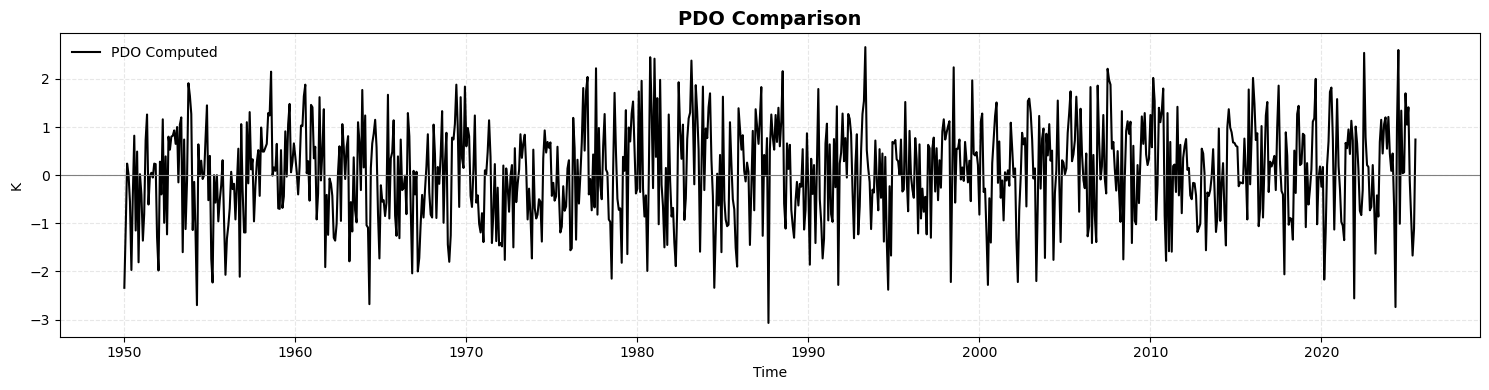

In [49]:
# Difference stems from the different climatology PDO - Climatology is 1920-2014.

plt.figure(figsize=(15, 4)) 
pna.PNA_index.plot(label = 'PDO Computed', linewidth=1.5, color = 'k')#, linestyle = 'dashed')
plt.axhline(0, color='gray', linewidth=0.8)
plt.title("PDO Comparison", fontsize=14, weight='bold')
plt.xlabel("Time")
plt.ylabel("K")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr

def compute_pna_index(
    z500_daily: xr.DataArray,
    pna_pattern: xr.DataArray,
    *,
    lat_name: str = "lat",
    lon_name: str = "lon",
    time_name: str = "time",
    anomaly: str = "daily",        # "daily", "monthly", or "none" (assumes anomalies already)
    smooth_doy: int = 31,          # odd window (days) for smoothing daily climatology
    lat_bounds: tuple = (0.0, 90.0),
    standardize: bool = True,      # z-score the index over its own time axis
    align_interp: bool = True      # if grids differ, interpolate pattern to data grid
) -> xr.DataArray:
    """
    Compute the PNA index by projecting a PNA loading pattern (2nd mode of a rotated-EOF)
    onto daily 500-hPa height anomalies over 0–90°N.

    Parameters
    ----------
    z500_daily : xr.DataArray
        Daily 500-hPa geopotential height with dims (..., time, lat, lon). Units: meters.
    pna_pattern : xr.DataArray
        PNA loading pattern on (lat, lon). Should be the 2nd mode from Rotated EOF of
        *monthly* z500 anomalies. Units arbitrary (pattern amplitude).
    lat_name, lon_name, time_name : str
        Dimension names.
    anomaly : {"daily","monthly","none"}
        - "daily": remove daily climatology (by day-of-year, smoothed by `smooth_doy`)
        - "monthly": remove monthly climatology
        - "none": assume input is already anomalies
    smooth_doy : int
        Rolling window (days) for smoothing the daily climatology (must be odd).
    lat_bounds : (float, float)
        Latitude range for projection (default 0–90°N).
    standardize : bool
        If True, z-score the resulting index over time.
    align_interp : bool
        If True and the pattern grid differs, interpolate pattern to z500 grid.

    Returns
    -------
    xr.DataArray
        Daily PNA index (dimension = time). Attributes include notes on processing.
    """
    # --- Basic checks
    if smooth_doy % 2 == 0:
        raise ValueError("smooth_doy must be an odd integer.")
    if time_name not in z500_daily.dims:
        raise ValueError(f"'{time_name}' dimension not found in z500_daily.")

    # --- Select 0–90°N
    z = z500_daily
    lat = z[lat_name]
    if lat[0] > lat[-1]:
        lat_slice = slice(lat_bounds[1], lat_bounds[0])  # descending
    else:
        lat_slice = slice(lat_bounds[0], lat_bounds[1])  # ascending
    z = z.sel({lat_name: lat_slice})

    # --- Align pattern: mask to same region & optionally interpolate to data grid
    pat = pna_pattern
    # ensure lon compatibility: wrap lon to same range if needed
    def _wrap(lon):
        # Convert to [0,360)
        lon360 = (lon % 360 + 360) % 360
        return lon360
    if lon_name in z.coords and lon_name in pat.coords:
        z = z.assign_coords({lon_name: _wrap(z[lon_name])}).sortby(lon_name)
        pat = pat.assign_coords({lon_name: _wrap(pat[lon_name])}).sortby(lon_name)

    pat = pat.sel({lat_name: z[lat_name].values}, method="nearest")
    pat = pat.sel({lon_name: z[lon_name].values}, method="nearest")

    if align_interp:
        # Interpolate pattern to z500 grid (cheap & dependency-free). Keeps NaNs.
        pat = pat.interp({lat_name: z[lat_name], lon_name: z[lon_name]})

    # --- Compute anomalies
    if anomaly == "daily":
        # day-of-year climatology (handle leap day by grouping dayofyear)
        # Smooth across DOY with a centered rolling window (wrap around using pad+roll)
        doy = z[time_name].dt.dayofyear
        clim = z.groupby(doy).mean(time_name, skipna=True)

        # pad for circular smoothing across DOY (assume 365-day calendar for smoothing)
        # If data has 366, we’ll include 366 as well; rolling handles available keys.
        clim_rolled = (
            clim
            .rolling({doy.name: smooth_doy}, center=True, min_periods=1)
            .mean()
        )
        anom = z.groupby(doy) - clim_rolled
    elif anomaly == "monthly":
        anom = z.groupby(f"{time_name}.month") - z.groupby(f"{time_name}.month").mean(time_name, skipna=True)
    elif anomaly == "none":
        anom = z
    else:
        raise ValueError("anomaly must be 'daily', 'monthly', or 'none'.")

    # --- Latitude weighting (sqrt(cos(lat))) for area weighting in projection
    wlat = np.cos(np.deg2rad(anom[lat_name]))
    w = xr.apply_ufunc(np.sqrt, wlat)  # sqrt-cos weighting
    # reshape for broadcasting
    w2d = w.broadcast_like(anom.isel({time_name: 0}, drop=False).squeeze(drop=True))
    # Some datasets need explicit expansion if time was singleton-sliced:
    if {lat_name, lon_name} != set(w2d.dims):
        w2d = w2d.transpose(lat_name, lon_name)

    # --- Ensure masks align (ignore grid points where pattern is NaN)
    mask = xr.ufuncs.isfinite(pat)
    anom_masked = anom.where(mask)
    pat_masked  = pat.where(mask)
    w_masked    = w2d.where(mask)

    # --- Normalize the pattern by its weighted power so the index is a true projection
    denom = (w_masked * (pat_masked ** 2)).sum(dim=(lat_name, lon_name), skipna=True)

    # Safety check
    if float(denom) == 0 or np.isnan(denom):
        raise ValueError("PNA pattern denominator is zero or NaN; check pattern/mask overlap.")

    # --- Projection: <anom, pattern> / <pattern, pattern>
    num = (w_masked * anom_masked * pat_masked).sum(dim=(lat_name, lon_name), skipna=True)
    pna_raw = num / denom  # units ~ meters per (pattern unit)

    # --- Standardize over time if requested
    if standardize:
        mu = pna_raw.mean(time_name, skipna=True)
        sd = pna_raw.std(time_name, skipna=True, ddof=1)
        pna = (pna_raw - mu) / sd
        pna.attrs["units"] = "standard deviations"
    else:
        pna = pna_raw
        pna.attrs["units"] = "unitless projection"

    # --- Metadata
    pna.name = "PNA"
    pna.attrs.update({
        "long_name": "Pacific-North American (PNA) index (daily)",
        "method": "Projection of rotated-EOF mode-2 loading pattern onto daily z500 anomalies over 0–90°N.",
        "weighting": "sqrt(cos(lat)) area weighting",
        "pattern_note": "Pattern should be REOF mode 2 from monthly z500 anomalies.",
        "lat_range": f"{lat_bounds[0]} to {lat_bounds[1]} degN",
        "anomaly_basis": anomaly,
        "standardized": str(standardize)
    })
    return pna

# z500_daily: xr.DataArray with dims (time, lat, lon), daily 500-hPa height [m]
# pna_pattern: xr.DataArray with dims (lat, lon) — REOF mode 2 (monthly anomalies)

# If z500 is raw daily heights, let the function remove daily climatology for you:
pna = compute_pna_index(z500_daily, pna_pattern, anomaly="daily", smooth_doy=31)

# If you already computed daily anomalies elsewhere:
# pna = compute_pna_index(z500_anom_daily, pna_pattern, anomaly="none")


## Loading SLP Indexes

SOI, SAM, NAM

### SOI

In [ ]:
#soi =xr.open_dataset(input_filepath1 +"index/soi_index_monthly.nc").SOI_index
soi_processed = process_climate_index(filepath = (input_filepath1 + "index/soi_index_monthly.nc"), 
                      varname = "SOI_index", 
                      label = "SOI")
print(list(soi_processed.keys()))

In [ ]:
plot_index_and_psd_combined(
    soi_processed['monthly_dt'], 
    filtered_data=soi_processed['monthly_dt_filtered'],
    label='SOI', smoothing=6, fs=12.0, xlim_psd=(0,0.5)
)
plt.show()

plot_index_and_psd_combined(
    soi_processed['seasonal_dt'],
    filtered_data=soi_processed['seasonal_dt_filtered'],
    label='SOI [Seasonal, Detrended, Filtered]', smoothing=6, fs=4.0, xlim_psd=(0,0.5)
)
plt.show()

#### OLD

In [ ]:
soi =xr.open_dataset(input_filepath1 +"index/soi_index_monthly.nc").SOI_index
soi = soi.sel(time=slice('1901-01-01', '2023-12-30'))
plot_index(soi, label='SOI Index 1901-2023 ', smoothing = 6)

soi_detrended = xr.DataArray(
    detrend(soi, type='linear'),
    coords=soi.coords,
    dims=soi.dims,
    name='SOI_detrended'
)

soi_detrended_seasonal = soi_detrended.resample(time='QS-DEC').mean(dim='time', skipna=False)#.groupby('time.season')
plot_index(soi_detrended, label='SOI Index 1901-2023 [Detrended]')

In [ ]:
# Resample to seasonal means (DJF, MAM, JJA, SON)
soi_seasonal = soi.resample(time='QS-DEC').mean(dim='time', skipna=False)
soi_seasonal = soi_seasonal.sel(time=slice('1902-12-01', '2023-11-30'))

# Group by season
soi_seasonal_grouped = soi_seasonal.groupby('time.season')
print(len(soi_seasonal_grouped['DJF']), len(soi_seasonal_grouped['JJA']), 
      len(soi_seasonal_grouped['MAM']), len(soi_seasonal_grouped['SON']))

# Detrend the seasonal SOI data
soi_seasonal_detrended = xr.DataArray(
    detrend(soi_seasonal, type='linear'),
    coords=soi_seasonal.coords,
    dims=soi_seasonal.dims,
    name='soi_seasonal_detrended'
)

# Plot the detrended SOI index
plot_index(soi_seasonal_detrended, label='SOI Index 1903–2023 [Detrended]')

# Apply 10-year low-pass filter to detrended SOI
soi_10_yr_seasonal_dt = apply_filter_xarray(
    soi_seasonal_detrended, order=8, cutoff=1/10, fs=4, 
    btype='low', padtype='even', padlen=120
)

# Plot filtered and detrended SOI index
plot_index_2(soi_seasonal_detrended, soi_10_yr_seasonal_dt, label='SOI [Detrended + Filtered]')


In [ ]:
soi_period_prominent = analyze_and_plot_cycle(soi_seasonal_detrended, label='ENSO Index', fs=12)
print(f"Dominant cycle: {soi_period_prominent:.2f} years")

In [ ]:
soi_period_prominent = analyze_and_plot_cycle(soi_10_yr_seasonal_dt, label='SOI Index [Filtered]', fs=12)
print(f"Dominant cycle: {soi_period_prominent:.2f} years")

In [ ]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def psd_welch(xarr, fs=12, nperseg=256, title='Welch PSD'):
    ts = xarr.dropna(dim='time').values
    freqs, pxx = welch(ts, fs=fs, nperseg=nperseg, window='hann', detrend='linear')
    
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, pxx)
    plt.title(title)
    plt.xlabel('Frequency (cycles/year)')
    plt.ylabel('PSD')
    plt.grid(True)
    plt.show()

    return freqs, pxx

soi_period_prominent = psd_welch(soi_seasonal_detrended)#, label='SOI Index [Filtered]', fs=12)


### SAM

Sea level pressure for this station was interpolated from the ECMWF Operational product from March 2025 onwards until further notice. 

For missing data a value is calculated using a monthly offset, calculated as the mean for the 1971-2000 period, from the Valdivia data. Efforts are ongoing at the Dirección Meteorológica de Chile to produce accurate monthly data from paper records prior to 1970: much of the early Valdivia data is taken from the World Weather Records dataset, which provides values only to the nearest hPa.

Mean values and standard deviations are calculated for the 30-year 1971-2000 period.

Marshall, G. J., 2003: Trends in the Southern Annular Mode from observations and reanalyses. J. Clim., 16, 4134-4143, doi:10.1175/1520-0442%282003%29016<4134%3ATITSAM>2.0.CO%3B2

data: https://legacy.bas.ac.uk/met/gjma/sam.html

In [68]:
sam_marshall = xr.open_dataset(input_filepath1 + "index/sam_index_monthly.nc")
sam_marshall 

<xarray.Dataset> Size: 13kB
Dimensions:    (time: 816)
Coordinates:
  * time       (time) datetime64[ns] 7kB 1957-01-01 1957-02-01 ... 2024-12-01
Data variables:
    SAM_index  (time) float64 7kB ...

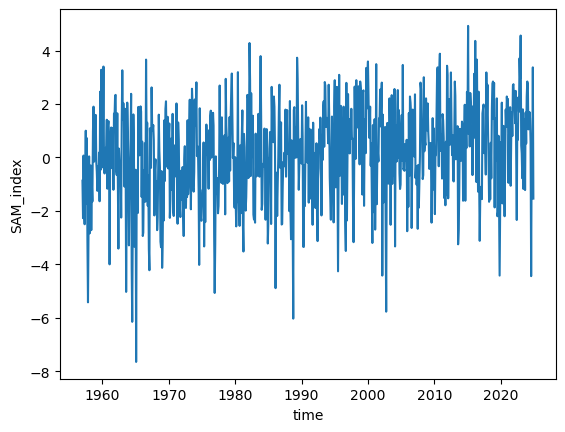

In [69]:
sam_marshall.SAM_index.plot()

### NAM

# OLD CODE

In [ ]:
# def plot_index(raw_data, label='Nino3.4', smoothing=6):
#     if hasattr(raw_data, 'rolling'):
#         smoothed = raw_data.rolling(time=smoothing, center=True).mean()
#     else:
#         smoothed = raw_data.rolling(window=smoothing, center=True).mean()

#     time = raw_data.time if hasattr(raw_data, 'time') else raw_data.index

#     plt.figure(figsize=(12, 4))
    
#     # Fill positive and negative anomalies
#     plt.fill_between(time, 0, raw_data, where=raw_data > 0, color='pink', alpha=0.8)
#     plt.fill_between(time, 0, raw_data, where=raw_data < 0, color='powderblue', alpha=0.8)

#     # Plot original and smoothed
#     plt.plot(time, raw_data, color='black', linewidth=0.5, label='Monthly')
#     #plt.plot(time, raw_data_no_filter, color='red', linewidth=0.5, label='Index')

#     plt.plot(time, smoothed, color='black', linewidth=1.2, label=f'{smoothing}-month running mean')

#     # Add horizontal line at 0
#     plt.axhline(0, color='k', linewidth=0.8)

#     plt.title(f'{label}')
#     plt.ylabel('Anomalies')
#     plt.xlabel('Year')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [ ]:
# def plot_index_2(raw_data, filtered_data, label='Nino3.4'):
    
#     plt.figure(figsize=(12, 4))
    
#     time = raw_data.time if hasattr(raw_data, 'time') else raw_data.index
   
#     # Fill positive and negative anomalies
#     plt.fill_between(time, 0, raw_data, where=raw_data > 0, color='pink', alpha=0.9)
#     plt.fill_between(time, 0, raw_data, where=raw_data < 0, color='powderblue', alpha=0.9)

#     # Plot original and smoothed
#     plt.plot(time, raw_data, color='black', linewidth=0.5, label='Monthly')
#     #plt.plot(time, raw_data_no_filter, color='red', linewidth=0.5, label='Index')
#     plt.plot(time, filtered_data, color='black', linewidth=1.5, label='Smoothed')

#     # Add horizontal line at 0
#     plt.axhline(0, color='k', linewidth=0.8)

#     plt.title(f'{label}')
#     plt.ylabel('Anomalies')
#     plt.xlabel('Year')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [ ]:
# ### PSD PLOTTED WITH FREQUENCY

# def plot_index_and_psd_combined(
#     raw_data,
#     filtered_data=None,
#     filter_label = "10-Yr Low Pass",
#     label='Index',
#     smoothing=6,                 # used only if filtered_data is None
#     fs=12.0,                     # samples per year (12 for monthly, 1 for annual)
#     nperseg=None,
#     detrend='constant',
#     scaling='density',
#     xlim_psd=(0, 0.5),
#     ylim_psd=None,
#     fill_anoms=True
# ):
#     """
#     Parameters
#     ----------
#     raw_data : xarray.DataArray or pandas.Series
#         Must have a 'time' coord / datetime index.
#     filtered_data : same type as raw_data or None
#         If None, uses a centered rolling mean of length 'smoothing'.
#     label : str
#         Title for the time series plot.
#     smoothing : int
#         Window length for centered rolling mean (if filtered_data is None).
#     fs : float
#         Sampling frequency in samples/year (12 monthly, 1 annual).
#     nperseg : int or None
#         Welch segment length. Default min(len, 256).
#     detrend : {'constant','linear'} or False
#         Detrend option passed to scipy.signal.welch.
#     scaling : {'density','spectrum'}
#         Welch scaling.
#     xlim_psd : (float,float)
#         X-axis limits for PSD (cycles/year).
#     ylim_psd : (float,float) or None
#         Y-axis limits for PSD.
#     fill_anoms : bool
#         Fill positive/negative anomalies in the time series panel.

#     Returns
#     -------
#     fig : matplotlib.figure.Figure
#     (freqs, pxx, peak_info) : tuple
#         PSD frequency array, PSD values, and a dict with peak info.
#     """
#     # --- Normalize inputs & extract time axis ---
#     # Try xarray first
#     if hasattr(raw_data, 'dims'):
#         if 'time' not in raw_data.dims:
#             raise ValueError("Input DataArray must have 'time' as a dimension")
#         da = raw_data
#         if raw_data.ndim > 1:
#             da = raw_data.mean(dim=[d for d in raw_data.dims if d != 'time'])
#         da = da.sortby('time').dropna(dim='time')
#         time = da.time.values
#         y = da.values
#         # filtered_data handling
#         if filtered_data is None:
#             smoothed = da.rolling(time=smoothing, center=True).mean()
#             y_smooth = smoothed.values
#         else:
#             fd = filtered_data
#             if hasattr(fd, 'dims'):
#                 if 'time' not in fd.dims:
#                     raise ValueError("filtered_data must have 'time' dimension")
#                 if fd.ndim > 1:
#                     fd = fd.mean(dim=[d for d in fd.dims if d != 'time'])
#                 fd = fd.sortby('time').dropna(dim='time')
#                 y_smooth = fd.values
#             else:
#                 # pandas-ish fallback
#                 y_smooth = filtered_data.values if hasattr(filtered_data, 'values') else np.asarray(filtered_data)
#     else:
#         # pandas Series / NumPy fallback
#         idx = raw_data.index if hasattr(raw_data, 'index') else None
#         if idx is None:
#             raise ValueError("If not xarray, raw_data must be a pandas Series with a datetime index.")
#         time = idx
#         y = raw_data.values
#         if filtered_data is None:
#             # centered rolling mean (odd window is nicer, but we’ll keep it simple)
#             sm = raw_data.rolling(window=smoothing, center=True).mean()
#             y_smooth = sm.values
#         else:
#             y_smooth = filtered_data.values if hasattr(filtered_data, 'values') else np.asarray(filtered_data)

#     # --- PSD (Welch) ---
#     if nperseg is None:
#         nperseg = min(len(y), 256)
#     freqs, pxx = welch(y, fs=fs, nperseg=nperseg, detrend=detrend, scaling=scaling)

#     # Peak detection (skip f=0 if present)
#     start = 1 if len(freqs) and freqs[0] == 0 else 0
#     peak_idx = start + np.argmax(pxx[start:])
#     peak_freq = freqs[peak_idx]          # cycles/year
#     peak_val = pxx[peak_idx]
#     peak_period_yrs = np.inf if peak_freq == 0 else 1.0 / peak_freq
#     peak_info = dict(idx=int(peak_idx), freq=float(peak_freq),
#                      value=float(peak_val), period_years=float(peak_period_yrs))

#     # --- Plot (two subplots, width ratio 4:1) ---
#     fig, (ax0, ax1) = plt.subplots(
#         1, 2, figsize=(20, 4.5),
#         gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.15}
#     )

#     # Left: time series
#     if fill_anoms:
#         ax0.fill_between(time, 0, y, where=y > 0, color='pink', alpha=0.9)
#         ax0.fill_between(time, 0, y, where=y < 0, color='powderblue', alpha=0.9)
#     ax0.plot(time, y, color='black', linewidth=0.5, label=label)
#     if y_smooth is not None:
#         ax0.plot(time, y_smooth, color='black', linewidth=1.5, label=filter_label)
#     ax0.axhline(0, color='k', linewidth=0.8)
#     ax0.set_title(label)
#     #ax0.set_ylabel('Anomalies')
#     ax0.set_xlabel('Year')
#     ax0.grid(True, alpha=0.3)
#     ax0.legend(frameon=False, loc='upper left')
#     #ax0.set_xlim(time[0].values, time[-1].values)

#     # Right: PSD
#     ax1.plot(freqs, pxx, '-k', label='PSD')
#     if np.isfinite(peak_info['period_years']):
#         ax1.axvline(peak_info['freq'], color='gray', linestyle=':', lw=1)
#         ax1.plot(peak_info['freq'], peak_info['value'], 'o', mfc='none', mec='red', mew=2)
#         ax1.legend(title=f"Peak ≈ {peak_info['period_years']:.2f} yrs", frameon=False)
#     else:
#         ax1.legend(frameon=False, loc='upper right')
#     ax1.set_xlabel('Frequency (cycles/year)')
#     ax1.set_ylabel('Power spectral density')
#     ax1.set_title('PSD')
#     if xlim_psd is not None:
#         ax1.set_xlim(*xlim_psd)
#     if ylim_psd is not None:
#         ax1.set_ylim(*ylim_psd)

#     plt.show()
#     return fig, (freqs, pxx, peak_info)

In [ ]:
# def linear_reg(djf_pc1, djf_sst, years):
#     djf_pc1['time'] = years
#     djf_sst['time'] = years
#     sst_pdsi_reg_pc1 = xr.cov(djf_pc1, djf_sst, dim="time")/djf_pc1.var(dim='time',skipna=True).values
#     return sst_pdsi_reg_pc1

# def linear_corr(djf_pc1, djf_sst, years):
#     djf_pc1['time'] = years
#     djf_sst['time'] = years
#     sst_pdsi_reg_pc1 = xr.corr(djf_pc1, djf_sst, dim="time")/djf_pc1.var(dim='time',skipna=True).values
#     return sst_pdsi_reg_pc1

In [ ]:
# SEASON_ORDER = ["DJF", "MAM", "JJA", "SON"]

# def _shift_season(season, offset):
#     i = SEASON_ORDER.index(season)
#     k = i + offset
#     return SEASON_ORDER[k % 4], k // 4

# def detrend_dim(da, dim="time"):
#     # safe, tiny linear detrend
#     n = int(da.sizes.get(dim, 0))
#     if n < 2:
#         return da
#     tnum = xr.DataArray(np.arange(n), dims=[dim], coords={dim: da[dim]})
#     pf = da.polyfit(dim=dim, deg=1, skipna=True)
#     return (da - xr.polyval(tnum, pf.polyfit_coefficients))

# def linear_reg_with_corr_p(pc_series, field, years=None):
#     # Optionally force a specific time axis; otherwise keep as-is
#     if years is not None:
#         pc_series = pc_series.copy()
#         field = field.copy()
#         pc_series["time"] = years
#         field["time"] = years

#     # Align on time intersection (avoids different coverages)
#     pc_series, field = xr.align(pc_series, field, join="inner")

#     n = int(field.sizes.get("time", 0))
#     if n < 3:
#         # Not enough samples: return NaN maps shaped like a single time-slice
#         base = field.isel(time=0, drop=True) * np.nan
#         return base, base, base

#     dof = n - 2
#     reg  = xr.cov(field, pc_series, dim="time")
#     corr = xr.corr(field, pc_series, dim="time")
#     tval = corr * np.sqrt(dof / (1 - corr**2))
#     p = xr.apply_ufunc(lambda x: 2 * (1 - t.cdf(np.abs(x), dof)), tval)
#     return reg, corr, p

# def compute_and_plot_reg_with_corrs_p_with_lag(
#     idx_values,
#     pdsi_anoms_seasonal,
#     sst_anoms_seasonal,
#     years, seasons,
#     lag_seasons=0,      # 0, 1, 2
#     lag_years=0,        # 0 or 1 (keep simple)
#     index_leads=True,   # True: index leads → field lags
#     cmap_pdsi="BrBG", vlim_pdsi=0.5,
#     cmap_sst="RdBu_r",  vlim_sst=0.5,
#     overall_title="Regression with Correlation P",
#     coeff_label="Regression",
# ):
#     pdsi_reg_dt, sst_reg_dt = [], []
#     pdsi_pvals_dt, sst_pvals_dt = [], []
#     dual_sel_titles = []

#     for season in seasons:
#         idx_s = idx_values[season]

#         tgt_season, wrap = _shift_season(season, lag_seasons if index_leads else -lag_seasons)
#         total_shift = wrap + (lag_years if index_leads else -lag_years)

#         pdsi_s = pdsi_anoms_seasonal[tgt_season]
#         sst_s  = sst_anoms_seasonal[tgt_season]

#         # Apply lag: shift the series that LAGS
#         if index_leads and total_shift:
#             pdsi_s = pdsi_s.shift(time=-total_shift)
#             sst_s  = sst_s.shift(time=-total_shift)
#         elif (not index_leads) and total_shift:
#             idx_s  = idx_s.shift(time=-total_shift)

#         # Align on time intersection AFTER shifts
#         idx_a, pdsi_a = xr.align(idx_s, pdsi_s, join="inner")
#         idx_a, sst_a  = xr.align(idx_a, sst_s,  join="inner")

#         # If no overlap, fill NaNs so plotting still runs
#         if int(idx_a.sizes.get("time", 0)) < 3:
#             nan_pdsi = pdsi_anoms_seasonal[tgt_season].isel(time=0, drop=True) * np.nan
#             nan_sst  = sst_anoms_seasonal[tgt_season].isel(time=0, drop=True) * np.nan
#             pdsi_reg_dt.append(nan_pdsi); sst_reg_dt.append(nan_sst)
#             pdsi_pvals_dt.append(nan_pdsi); sst_pvals_dt.append(nan_sst)
#             dual_sel_titles.append(f"{season} (no overlap)")
#             continue

#         # Detrend
#         idx_dt  = detrend_dim(idx_a,  "time")
#         pdsi_dt = detrend_dim(pdsi_a, "time")
#         sst_dt  = detrend_dim(sst_a,  "time")

#         # Use the already-aligned time; don't force external `years`
#         reg_pdsi, corr_pdsi, p_pdsi = linear_reg_with_corr_p(idx_dt, pdsi_dt)
#         reg_sst,  corr_sst,  p_sst  = linear_reg_with_corr_p(idx_dt, sst_dt)

#         pdsi_reg_dt.append(reg_pdsi); sst_reg_dt.append(reg_sst)
#         pdsi_pvals_dt.append(p_pdsi); sst_pvals_dt.append(p_sst)

#         lag_txt = []
#         if lag_seasons: lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_seasons} season")
#         if lag_years:   lag_txt.append(f"{'index→field' if index_leads else 'field→index'} {lag_years} yr")
#         dual_sel_titles.append(f"{season} ({', '.join(lag_txt) if lag_txt else 'no lag'})")

#     # your existing plotter
#     four_reg_plot_with_sig(
#         pdsi_reg_dt, cmap_pdsi, vlim_pdsi,
#         sst_reg_dt,  cmap_sst,  vlim_sst,
#         pdsi_pvals_dt, sst_pvals_dt,
#         dual_sel_titles,
#         overall_title,
#         coeff_label
#     )

#     return {
#         "pdsi_reg": pdsi_reg_dt,
#         "sst_reg":  sst_reg_dt,
#         "pdsi_pvals": pdsi_pvals_dt,
#         "sst_pvals":  sst_pvals_dt
#     }


# Bottom